In [1]:
%load_ext autoreload
%autoreload 2

import collections
import os
import pickle
from typing import List, Tuple, Union

import matplotlib.pyplot as plt
import neurokit2 as nk
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import wfdb
from data_analysis_octopus import *
from IPython.display import clear_output
from joblib import Parallel, delayed
from sklearn import metrics
from sklearn.base import clone
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB, GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

ModelClassifier = Union[SVC, KNeighborsClassifier, DecisionTreeClassifier,
                       GaussianNB, MultinomialNB, ComplementNB,
                       LogisticRegression, XGBClassifier]

def read_wfdb_file(file):
    record = wfdb.rdrecord(file)
    return record 


def from_wsdb_to_pandas(record):
    signal = record.p_signal
    signal_df = pd.DataFrame(signal, columns=[f"Signal_{i+1}" for i in range(signal.shape[1])])

    return signal_df


def extract_ecg_features(signals_array, fs=500):
    features_dict = {}

    for i in range(signals_array.shape[1]):
        signal = signals_array[:, i]
        
        # Procesamiento del ECG con neurokit2
        ecg_signals, info = nk.ecg_process(signal, sampling_rate=fs)

        # Frecuencia cardíaca
        heart_rate_mean = ecg_signals["ECG_Rate"].mean()
        heart_rate_std = ecg_signals["ECG_Rate"].std()

        # Intervalo PR
        if "ECG_P_Onsets" in ecg_signals and "ECG_R_Onsets" in ecg_signals:
            pr_intervals = ecg_signals["ECG_P_Onsets"] - ecg_signals["ECG_R_Onsets"]
            pr_mean = np.mean(pr_intervals)
        else:
            pr_mean = np.nan

        # Intervalo QRS
        if "ECG_S_Peaks" in ecg_signals and "ECG_Q_Peaks" in ecg_signals:
            qrs_intervals = ecg_signals["ECG_S_Peaks"] - ecg_signals["ECG_Q_Peaks"]
            qrs_mean = np.mean(qrs_intervals)
        else:
            qrs_mean = np.nan

        # Intervalo QT
        if "ECG_T_Onsets" in ecg_signals and "ECG_Q_Onsets" in ecg_signals:
            qt_intervals = ecg_signals["ECG_T_Onsets"] - ecg_signals["ECG_Q_Onsets"]
            qt_mean = np.mean(qt_intervals)
        else:
            qt_mean = np.nan

        # Segmento ST
        if "ECG_Segments_ST" in ecg_signals:
            st_segment_mean = np.mean(ecg_signals["ECG_Segments_ST"])
        else:
            st_segment_mean = np.nan

        # Onda T
        if "ECG_Waves_T_Height" in ecg_signals:
            t_wave_mean = np.mean(ecg_signals["ECG_Waves_T_Height"])
        else:
            t_wave_mean = np.nan

        # Variabilidad de la frecuencia cardíaca (HRV)
        if "ECG_RR_Intervals" in ecg_signals:
            hrv_sdnn = np.std(ecg_signals["ECG_RR_Intervals"])  # Desviación estándar de los intervalos RR
        else:
            hrv_sdnn = np.nan

        # Análisis de dominio de frecuencia (FFT)
        if "ECG_Clean" in ecg_signals:
            fft_result = np.fft.fft(ecg_signals["ECG_Clean"])
            # fft_freqs = np.fft.fftfreq(len(ecg_signals["ECG_Clean"]), d=1/fs)
            max_freq_component = np.max(np.abs(fft_result))
        else:
            max_freq_component = np.nan

        # Almacenar características en el diccionario
        col_name = f"Column_{i + 1}"  # Nombre de la columna
        features_dict[f"{col_name}_HeartRate_Mean"] = heart_rate_mean
        features_dict[f"{col_name}_HeartRate_STD"] = heart_rate_std
        features_dict[f"{col_name}_PR_Interval_Mean"] = pr_mean
        features_dict[f"{col_name}_QRS_Interval_Mean"] = qrs_mean
        features_dict[f"{col_name}_QT_Interval_Mean"] = qt_mean
        features_dict[f"{col_name}_ST_Segment_Mean"] = st_segment_mean
        features_dict[f"{col_name}_T_Wave_Mean"] = t_wave_mean
        features_dict[f"{col_name}_HRV_SDNN"] = hrv_sdnn
        features_dict[f"{col_name}_Max_Freq_Component"] = max_freq_component

    # Convertir el diccionario de características en un DataFrame
    features_df = pd.DataFrame(features_dict, index=[0])

    return features_df


def get_ecg_features_from_file(file): 
    record = read_wfdb_file(file)
    signal = record.p_signal
    # signals_df = from_wsdb_to_pandas(record)
    features_df = extract_ecg_features(signal)
    
    return features_df


def process_file(file, results_file):
    try:
        tmp_df = get_ecg_features_from_file(file)
        tmp_df.insert(loc=0, column="filename_hr", value=file)
        
        tmp_df.to_csv(results_file, index=False, mode="a", header=not os.path.exists(results_file))
        
    except Exception as e:
        return file


def freq_discrete(df, features):
    for feature in features:
        print(f"Feature: {feature}")
        abs_ = df[feature].value_counts(dropna=False).to_frame().rename(columns={"count": "Absolute frequency"})
        rel_ = df[feature].value_counts(dropna=False, normalize= True).to_frame().rename(columns={"proportion": "Relative frequency"})
        freq = abs_.join(rel_)
        freq["Accumulated frequency"] = freq["Absolute frequency"].cumsum()
        freq["Accumulated %"] = freq["Relative frequency"].cumsum()
        freq["Absolute frequency"] = freq["Absolute frequency"].map(lambda x: "{:,.0f}".format(x))
        freq["Relative frequency"] = freq["Relative frequency"].map(lambda x: "{:,.2%}".format(x))
        freq["Accumulated frequency"] = freq["Accumulated frequency"].map(lambda x: "{:,.0f}".format(x))
        freq["Accumulated %"] = freq["Accumulated %"].map(lambda x: "{:,.2%}".format(x))
        display(freq)


def get_features_in_parallel(data, results_filename, errors_filename, num_cores):
    files_list = []
    if os.path.exists(results_filename):
        results_df = pd.read_csv(results_filename)
        files_list = results_df["filename_hr"].to_list()

    errors_list = []
    if os.path.exists(errors_filename):
        errors = pd.read_csv(errors_filename)
        errors_list = errors["file"].to_list()

    files_list = files_list + errors_list
    filtered_df = data[data["filename_hr"].isin(files_list) == False]

    results = Parallel(n_jobs=num_cores)(
        delayed(process_file)(file, results_filename) for file in filtered_df["filename_hr"].to_list()
    )

    errors_df = pd.DataFrame({"file": results})
    errors_df[errors_df["file"].notnull()].to_csv(errors_filename, index=False, mode="a")


def get_features_by_xgb_importance(
        model: XGBClassifier, importance_type: str) -> List:
    """Returns a list with the features sorted by importance"""

    imp_scores_d = model.get_booster().get_score(
        importance_type=importance_type)
    sorted_imp = sorted(imp_scores_d.items(), key=lambda kv: kv[1])
    sorted_dict = collections.OrderedDict(sorted_imp)

    return [key for key in sorted_dict.keys()]

def estimate_score_metrics(y_test: pd.Series,
                           y_pred: np.ndarray,
                           y_prob: np.ndarray
                           ) -> Tuple[float, float, int, int, int, int]:
    """Returns the following evaluation metrics: ROC, ROC_AUC,
    \rF1-score, Recall, Accuracy, Brier"""
    roc = round(metrics.roc_auc_score(y_test, y_pred), 2)
    roc_auc = round(metrics.roc_auc_score(y_test, y_prob), 2)

    f1 = round(metrics.f1_score(y_test, y_pred) * 100)
    recall = round(metrics.recall_score(y_test, y_pred) * 100)
    accuracy = round(metrics.accuracy_score(y_test, y_pred) * 100)
    brier = round(metrics.brier_score_loss(y_test, y_pred) * 100)

    return roc, roc_auc, f1, recall, accuracy, brier


def get_total_iterations(model, importance_types_list: List) -> int:
    """Returns the total of iterations for the modeling by xgb
    feature importance"""
    no_elements = 1
    for imp_type in importance_types_list:
        features = get_features_by_xgb_importance(
            model=model, importance_type=imp_type)

        while len(features) > 0:
            _ = features.pop(0)
            no_elements += 1

    return no_elements

def modeling_by_subset(
        model: ModelClassifier,
        x_train: pd.DataFrame,
        y_train: Union[pd.Series, pd.DataFrame],
        features: List) -> np.array:
    """Returns an array with Machine Learning model, identifier of model,
    number of features, metrics scores, """
    return model.fit(x_train[features], y_train)


def predict_by_subset(
        predictor: ModelClassifier,
        x_test: pd.DataFrame,
        features: List) -> np.array:
    """Returns an array with Machine Learning model, identifier of model,
    number of features, metrics scores, """
    x_test_subset = x_test[features]
    y_pred = predictor.predict(x_test_subset)
    y_prob = np.around(predictor.predict_proba(x_test_subset)[:, 1], 2)

    return y_pred, y_prob


def modeling_by_xgb_importance(
        model_name: str,
        model: ModelClassifier,
        x_train: pd.DataFrame,
        y_train: pd.DataFrame,
        x_test: pd.DataFrame,
        y_test) -> pd.DataFrame:
    """Returns a dataframe of models scores using xgboost feature
    \r importance to select the best features
    """
    gral_model = XGBClassifier(n_jobs=-1)
    gral_model_fitted = gral_model.fit(x_train, y_train)
    imp_types_lst = ["total_gain", "total_cover", "weight", "gain", "cover"]

    no_elements = get_total_iterations(gral_model_fitted, imp_types_lst)
    count = 1
    row_lst: List[np.array] = []
    row_array = np.array(row_lst)

    for importance_type in imp_types_lst:
        features_list = get_features_by_xgb_importance(
            model=gral_model_fitted, importance_type=importance_type)

        while len(features_list) > 0:

            predictor = modeling_by_subset(model=clone(model),
                                           x_train=x_train,
                                           y_train=y_train,
                                           features=features_list)

            y_pred, y_prob = predict_by_subset(predictor=predictor,
                                               x_test=x_test,
                                               features=features_list)

            score_metrics = estimate_score_metrics(
                y_test=y_test, y_pred=y_pred, y_prob=y_prob)

            row_lst.append(np.array([
                model_name,
                "model_" + str(count),
                len(features_list),
                *score_metrics,
                importance_type,
                ",".join(features_list)]))

            count += 1
            _ = features_list.pop(0)

            txt = "of " + " Modeling with " + str(model_name) + " :"
            update_progress(count / no_elements, progress_text=txt)

        row_array = np.array(row_lst)

    # Names of columns of info value dataframe
    cols_dict = {
        "Models": str, "Id": str, "No_features": int, "ROC": float,
        "ROC_AUC": float, "F1": float, "Recall": float, "Accuracy": float,
        "Brier": float, "Importance_type": str, "Best_features": str,}

    cols_name = [names for names in cols_dict]
    df = pd.DataFrame(data=row_array, columns=cols_name)
    df = df.astype(cols_dict)

    df = df.sort_values(["F1", "ROC_AUC", "No_features"],
                        ascending=False).reset_index(drop=True)

    clear_output(wait=False)

    return df


def update_progress(progress, progress_text=""):
    """ Print the progress of a "FOR" inside a function """

    bar_length = 40
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    progress = max(progress, 0)
    progress = min(progress, 1)
    block = int(round(bar_length * progress))
    clear_output(wait=True)
    text = " ".join(["Progress", progress_text, "[{0}] {1:.1f}%"])
    ouput_text = text.format("#" * block + "-" * (bar_length - block),
                             progress * 100)

    print(ouput_text)

In [2]:
raw_df = pd.read_csv("../data/electrocardiograma/train_e1.csv")
raw_df.head(1)

ecg_id  patient_id   age  sex  height  weight  nurse  site      device  \
0   16286     10874.0  68.0    0     NaN     NaN    0.0   0.0  CS100    3   

        recording_date                filename_hr  NOT_NORM  
0  1996-07-04 14:12:49  records500/16000/16286_hr         1

## Agregando datos de los electrocardiogramas

In [3]:
raw_df.loc[:, "filename_hr"] = "../data/electrocardiograma/" + raw_df["filename_hr"]

In [19]:
get_features_in_parallel(
    raw_df, results_filename="resultados_ecg_train.csv",
    errors_filename="error_files_train.csv", num_cores=8
)

In [4]:
features_df = pd.read_csv("resultados_ecg_train.csv")
features_df.shape

(14571, 109)

In [5]:
df = raw_df.merge(features_df, on="filename_hr", how="right")
print(df.shape)
df.head(1)

(14571, 120)


ecg_id  patient_id   age  sex  height  weight  nurse  site      device  \
0    8747      1465.0  58.0    0     NaN     NaN    NaN   4.0  AT-6     6   

        recording_date  ... Column_11_Max_Freq_Component  \
0  1992-08-10 18:18:04  ...                   305.751721   

   Column_12_HeartRate_Mean  Column_12_HeartRate_STD  \
0                 55.506065                 0.717123   

   Column_12_PR_Interval_Mean  Column_12_QRS_Interval_Mean  \
0                      0.0002                          0.0   

   Column_12_QT_Interval_Mean  Column_12_ST_Segment_Mean  \
0                         NaN                        NaN   

   Column_12_T_Wave_Mean  Column_12_HRV_SDNN  Column_12_Max_Freq_Component  
0                    NaN                 NaN                    247.567805  

[1 rows x 120 columns]

In [6]:
target = "NOT_NORM"
df[target].value_counts(normalize=True).to_frame()

proportion
NOT_NORM            
1           0.563517
0           0.436483

## Train & test

In [7]:
mask = [
    "ecg_id",
    "patient_id",
    "nurse",
    "site",
    "device",
    "recording_date",
    "filename_hr",
    target
]

X = df[df.columns[df.columns.isin(mask) == False]]
y = df[[target]]

squeezed_y = y.squeeze()
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, squeezed_y, test_size=0.25, random_state=42, stratify=squeezed_y)

y_train.to_pickle("../results/9-Electrocardiograma/y_train.pickle")
y_test.to_pickle("../results/9-Electrocardiograma/y_test.pickle")

## Análisis & Preprocesamiento

In [24]:
features = [
    "age",
    "sex",
    "height",
    "weight"
]

df[features].describe()

age           sex       height      weight
count  14516.000000  14571.000000  4664.000000  6398.00000
mean      59.490218      0.482053   166.810678    70.90669
std       17.127508      0.499695    10.891387    15.80832
min        2.000000      0.000000     6.000000    12.00000
25%       49.000000      0.000000   160.000000    60.00000
50%       61.000000      0.000000   167.000000    70.00000
75%       72.000000      1.000000   175.000000    80.00000
max       95.000000      1.000000   200.000000   210.00000

In [25]:
freq_discrete(df, ["sex"])

Feature: sex


Absolute frequency Relative frequency Accumulated frequency Accumulated %
sex                                                                          
0                7,547             51.79%                 7,547        51.79%
1                7,024             48.21%                14,571       100.00%

### Detección y remoción de variables poco pobladas

In [8]:
THRESHOLD = 65
completitud_df = DataViz.completitud(X_train_raw)
remove_features = completitud_df[completitud_df["% valores nulos"] >= THRESHOLD]
remove_features

features  Total de nulos  % valores nulos
2                        height            7435            68.04
8     Column_1_QT_Interval_Mean           10928           100.00
9      Column_1_ST_Segment_Mean           10928           100.00
10         Column_1_T_Wave_Mean           10928           100.00
11            Column_1_HRV_SDNN           10928           100.00
17    Column_2_QT_Interval_Mean           10928           100.00
18     Column_2_ST_Segment_Mean           10928           100.00
19         Column_2_T_Wave_Mean           10928           100.00
20            Column_2_HRV_SDNN           10928           100.00
26    Column_3_QT_Interval_Mean           10928           100.00
27     Column_3_ST_Segment_Mean           10928           100.00
28         Column_3_T_Wave_Mean           10928           100.00
29            Column_3_HRV_SDNN           10928           100.00
35    Column_4_QT_Interval_Mean           10928           100.00
36     Column_4_ST_Segment_Mean           10928           100.00
37         Column_4_T_Wave_Mean           10928           100.00
38            Column_4_HRV_SDNN           10928           100.00
44    Column_5_QT_Interval_Mean           10928           100.00
45     Column_5_ST_Segment_Mean           10928           100.00
46         Column_5_T_Wave_Mean           10928           100.00
47            Column_5_HRV_SDNN           10928           100.00
53    Column_6_QT_Interval_Mean           10928           100.00
54     Column_6_ST_Segment_Mean           10928           100.00
55         Column_6_T_Wave_Mean           10928           100.00
56            Column_6_HRV_SDNN           10928           100.00
62    Column_7_QT_Interval_Mean           10928           100.00
63     Column_7_ST_Segment_Mean           10928           100.00
64         Column_7_T_Wave_Mean           10928           100.00
65            Column_7_HRV_SDNN           10928           100.00
71    Column_8_QT_Interval_Mean           10928           100.00
72     Column_8_ST_Segment_Mean           10928           100.00
73         Column_8_T_Wave_Mean           10928           100.00
74            Column_8_HRV_SDNN           10928           100.00
80    Column_9_QT_Interval_Mean           10928           100.00
81     Column_9_ST_Segment_Mean           10928           100.00
82         Column_9_T_Wave_Mean           10928           100.00
83            Column_9_HRV_SDNN           10928           100.00
89   Column_10_QT_Interval_Mean           10928           100.00
90    Column_10_ST_Segment_Mean           10928           100.00
91        Column_10_T_Wave_Mean           10928           100.00
92           Column_10_HRV_SDNN           10928           100.00
98   Column_11_QT_Interval_Mean           10928           100.00
99    Column_11_ST_Segment_Mean           10928           100.00
100       Column_11_T_Wave_Mean           10928           100.00
101          Column_11_HRV_SDNN           10928           100.00
107  Column_12_QT_Interval_Mean           10928           100.00
108   Column_12_ST_Segment_Mean           10928           100.00
109       Column_12_T_Wave_Mean           10928           100.00
110          Column_12_HRV_SDNN           10928           100.00

In [9]:
remove_columns = remove_features["features"].to_list()
X_train_raw = X_train_raw.drop(columns=remove_columns)
X_train_raw.shape

(10928, 63)

In [10]:
mask = X_train_raw.columns[X_train_raw.columns.isin(["sex"])== False]
numerical_features = X_train_raw[mask].columns.to_list()
categorical_features = ["sex"]

X_train, X_test, preprocessor = transform_data(
    X_train_raw, X_test_raw, numerical_features=numerical_features,
    categorical_features=categorical_features)

# Checkpoint
with open("../results/9-Electrocardiograma/preprocessor.pickle", "wb") as f:
    pickle.dump(preprocessor, f)

with open("../results/9-Electrocardiograma/numerical_features.pickle", "wb") as f:
    pickle.dump(numerical_features, f)

with open("../results/9-Electrocardiograma/categorical_features.pickle", "wb") as f:
    pickle.dump(categorical_features, f)

X_train.to_pickle("../results/9-Electrocardiograma/X_train.pickle")
X_test.to_pickle("../results/9-Electrocardiograma/X_test.pickle")

In [31]:
# Checkpoint
with open("../results/9-Electrocardiograma/numerical_features.pickle", "rb") as f:
    numerical_features = pickle.load(f)

with open("../results/9-Electrocardiograma/categorical_features.pickle", "rb") as f:
    categorical_features = pickle.load(f)

target = "NOT_NORM"

X_train = pd.read_pickle("../results/9-Electrocardiograma/X_train.pickle")
X_test = pd.read_pickle("../results/9-Electrocardiograma/X_test.pickle")
y_train = pd.read_pickle("../results/9-Electrocardiograma/y_train.pickle")
y_test = pd.read_pickle("../results/9-Electrocardiograma/y_test.pickle")

processed_df = pd.concat([y_train, X_train], axis=1)

## Distribuciones

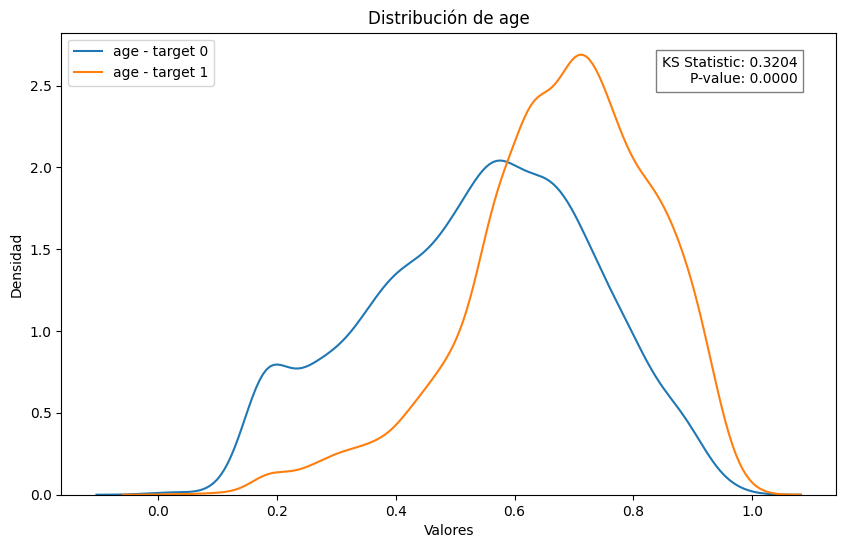

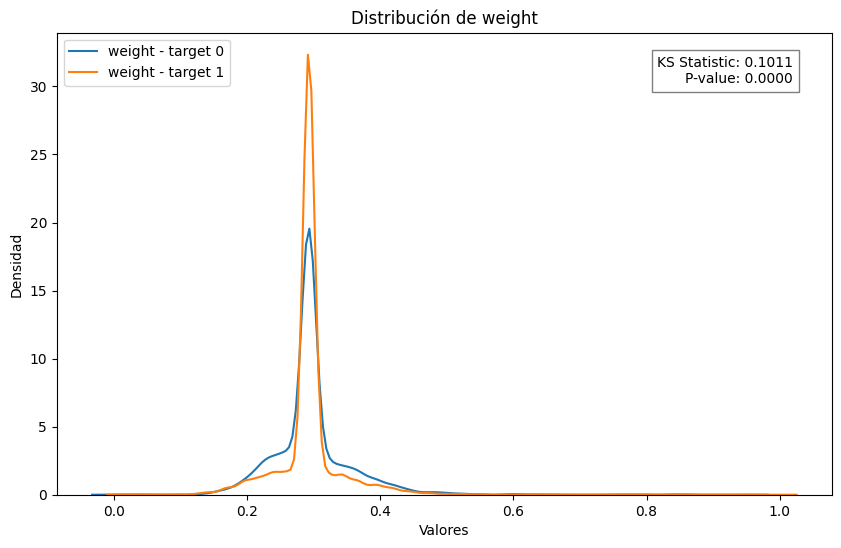

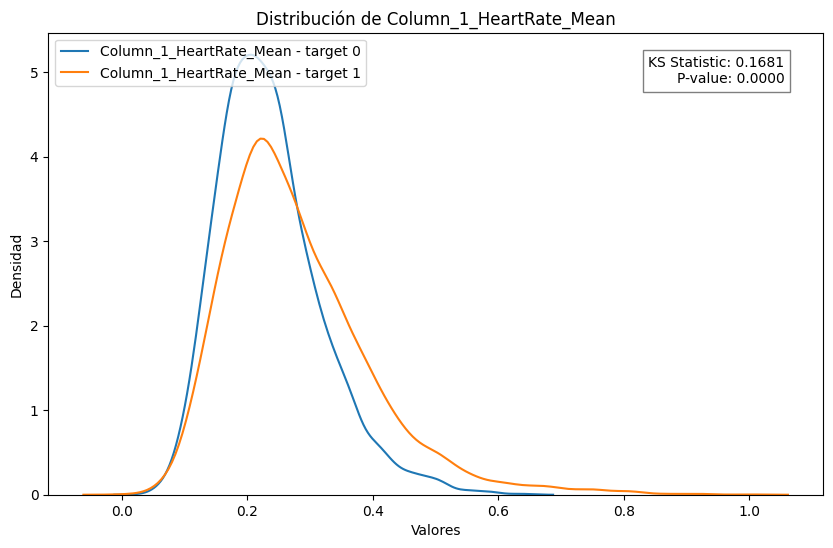

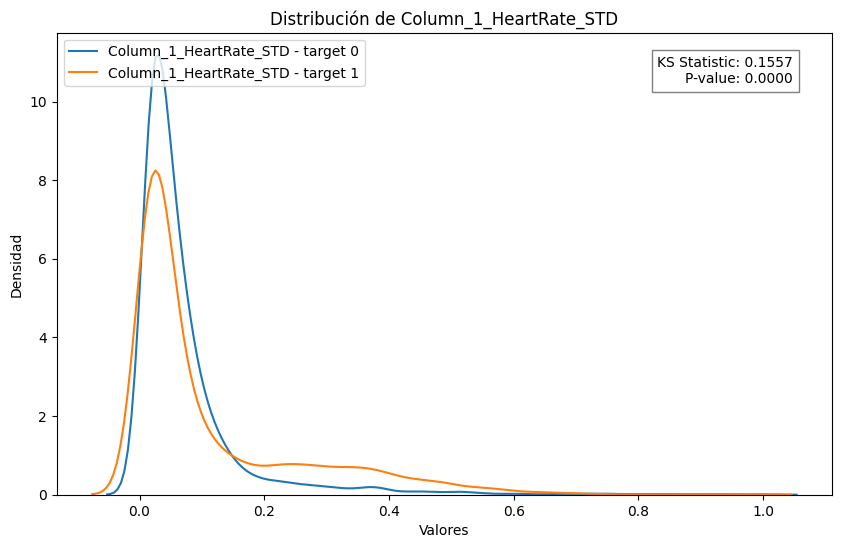

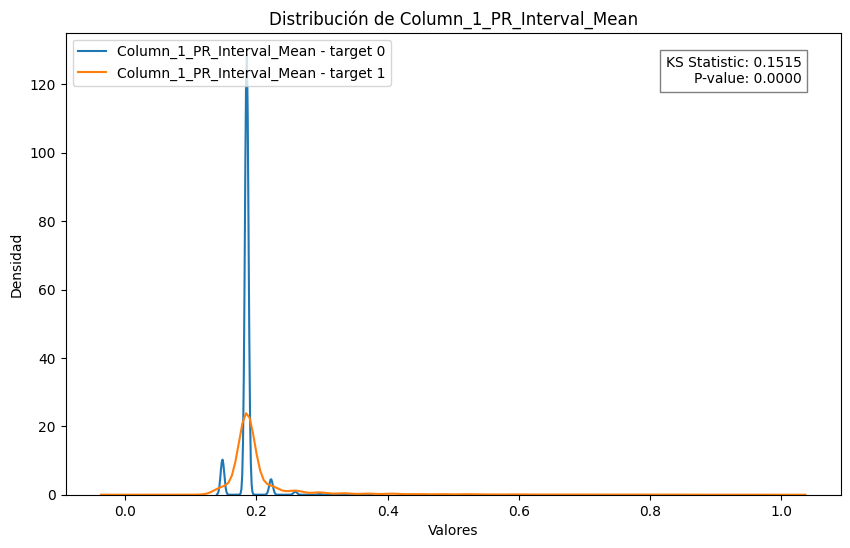

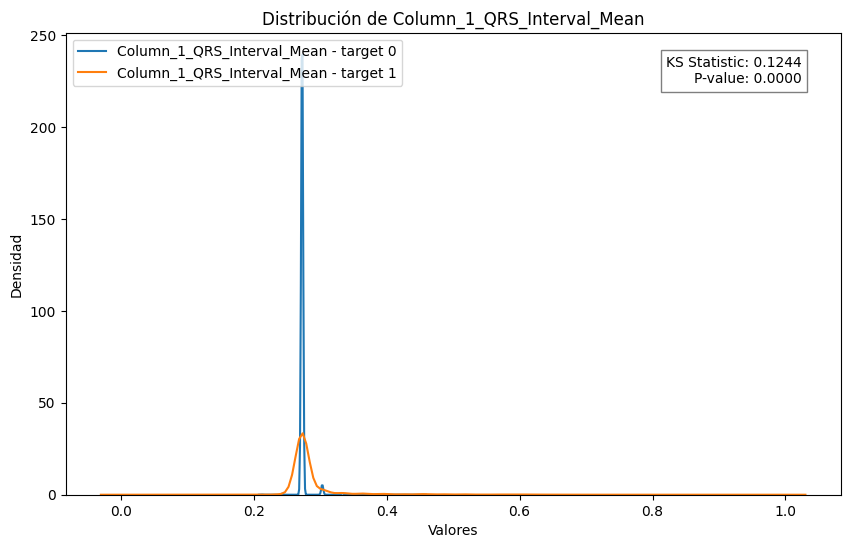

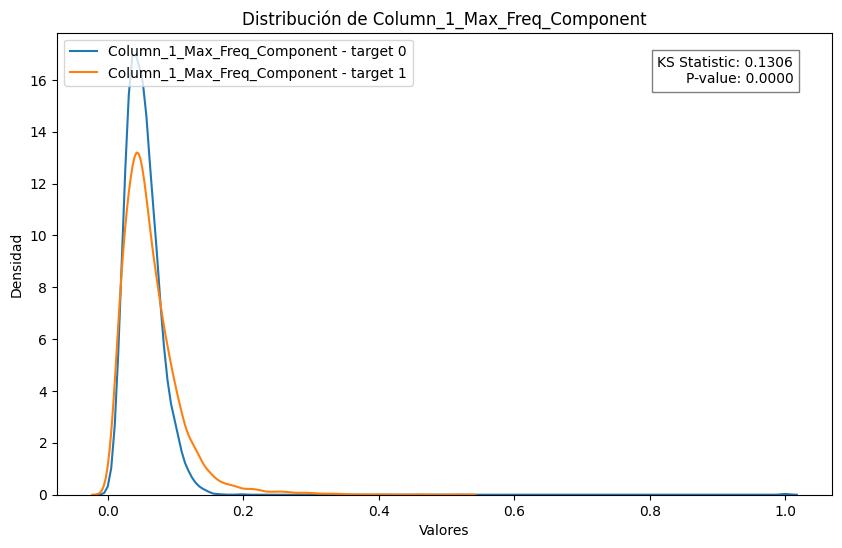

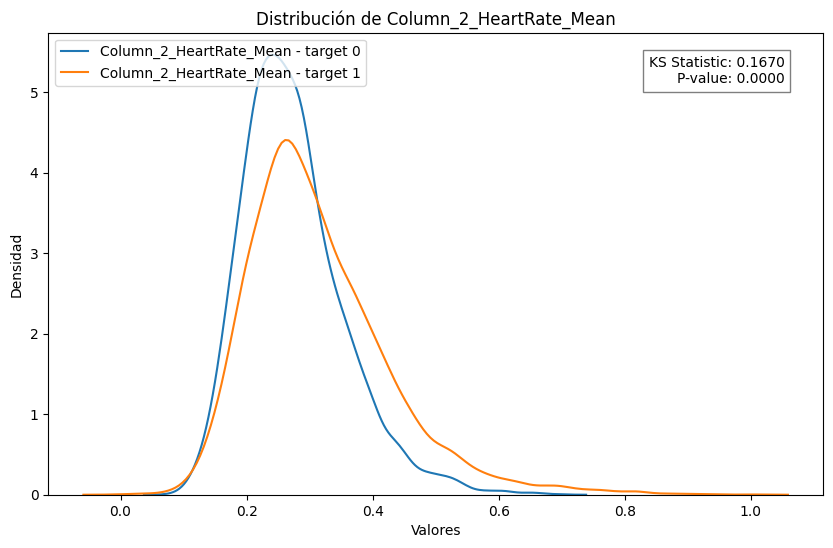

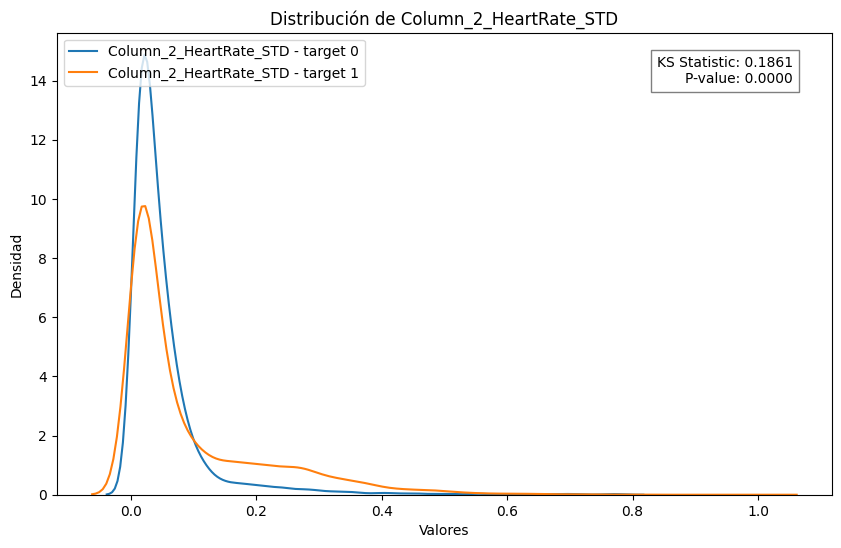

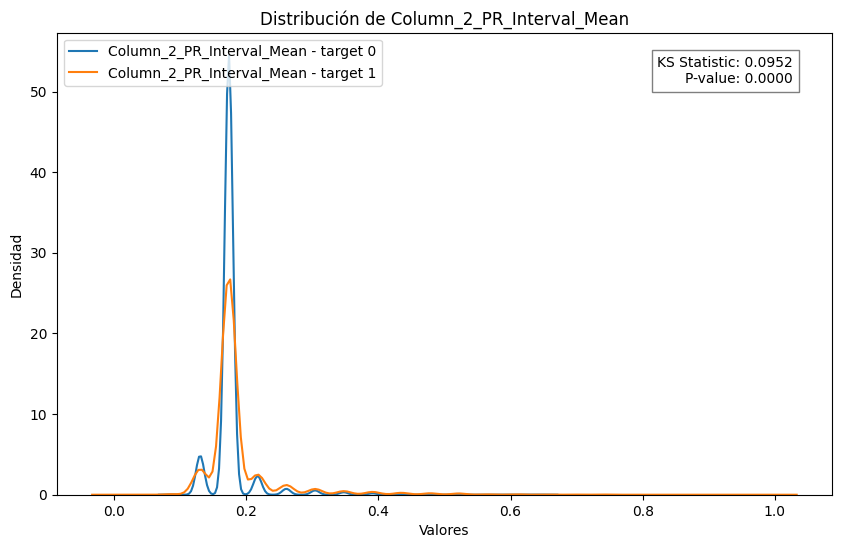

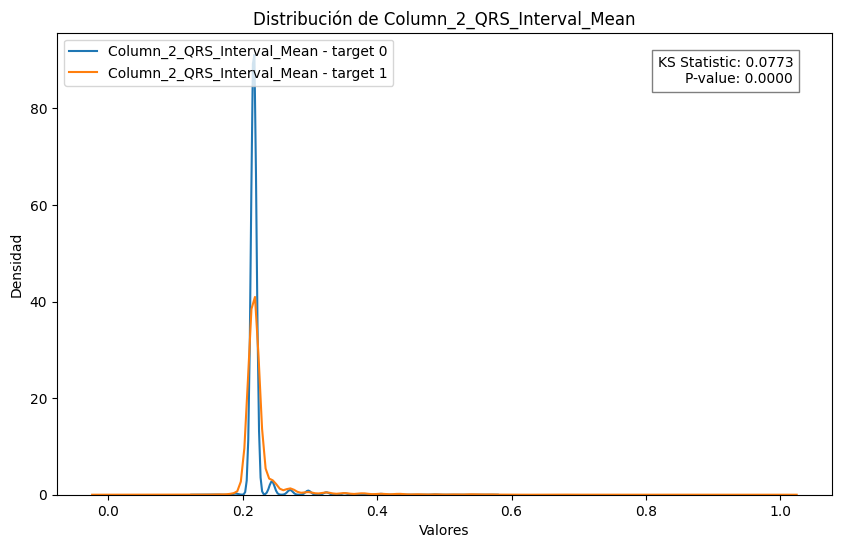

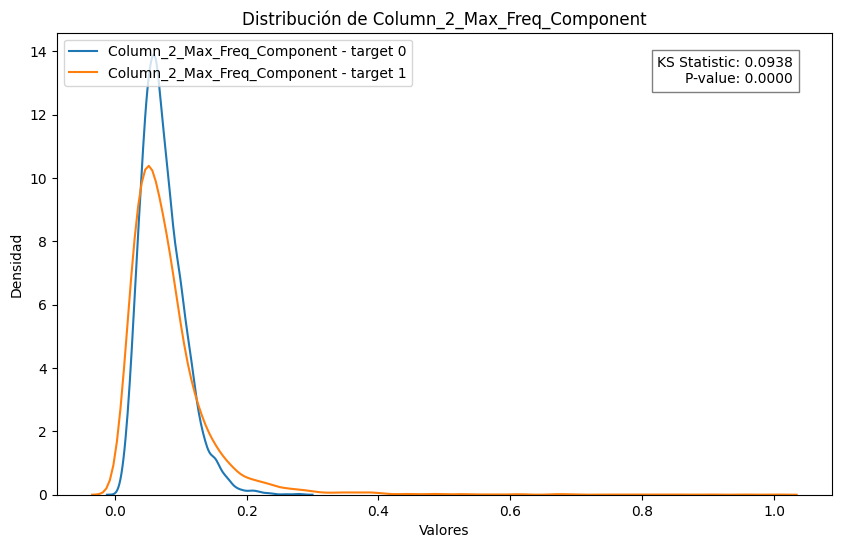

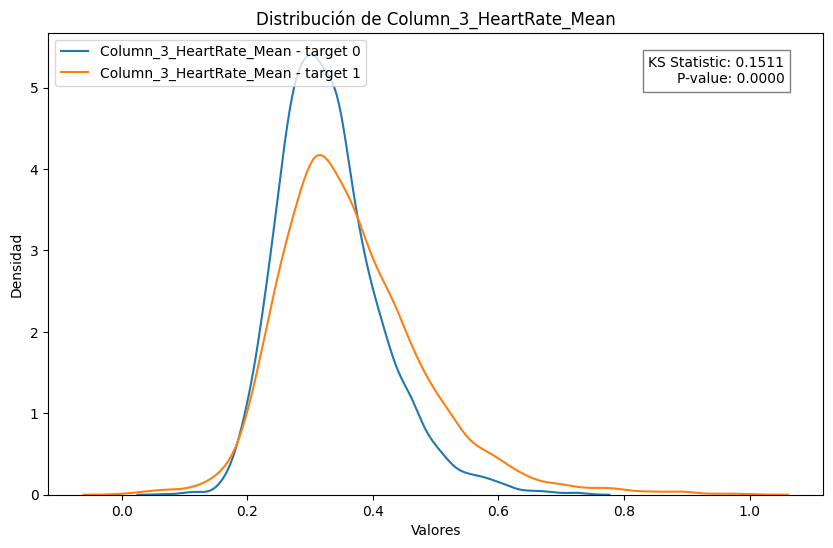

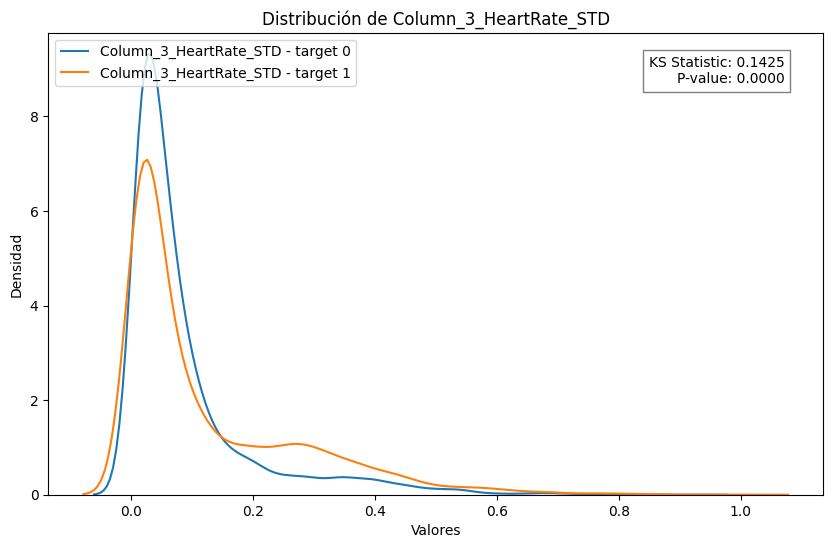

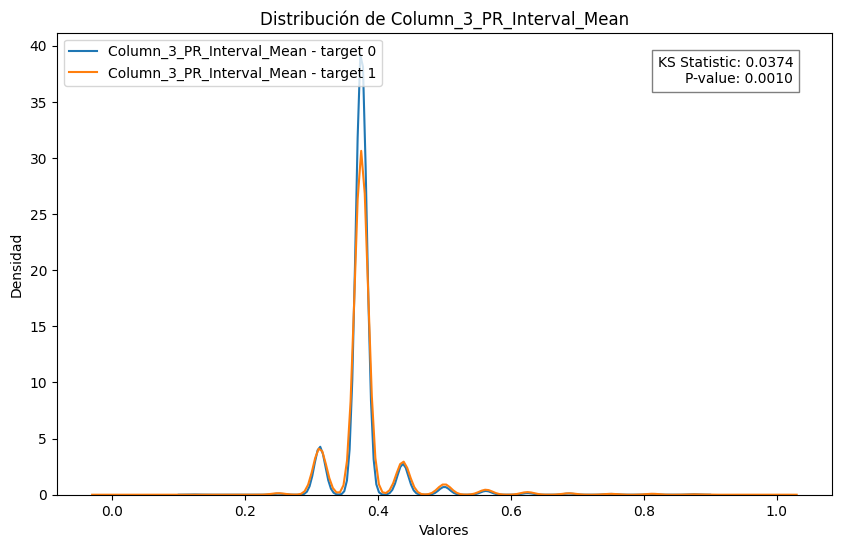

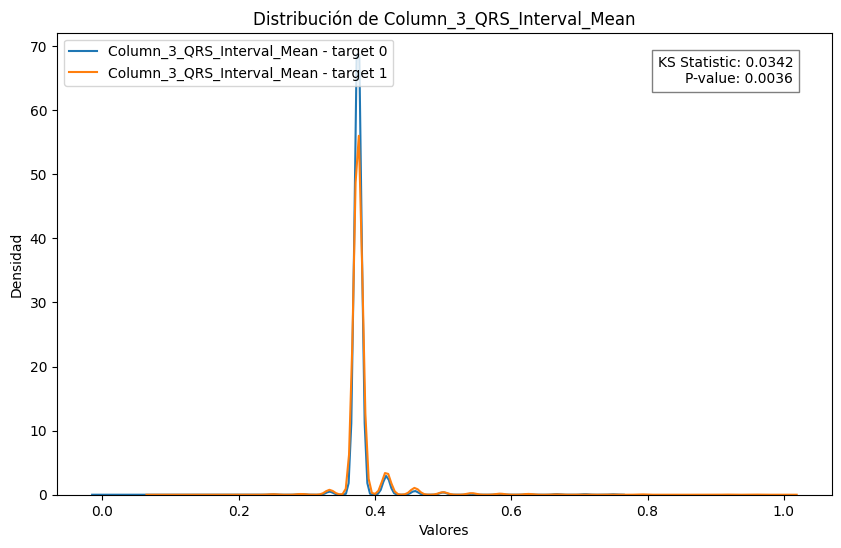

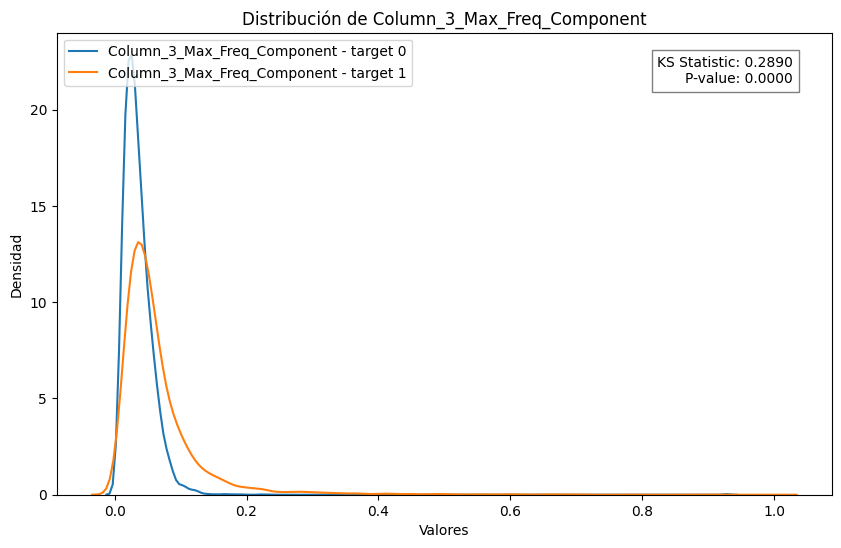

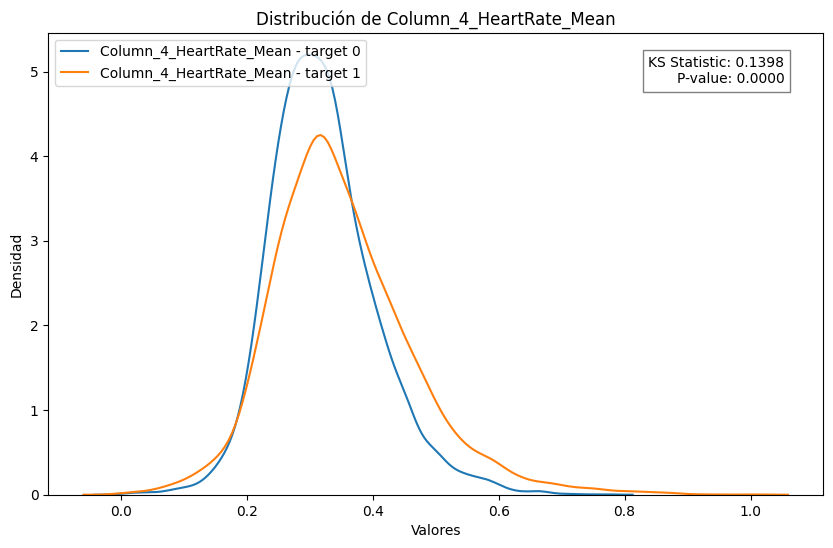

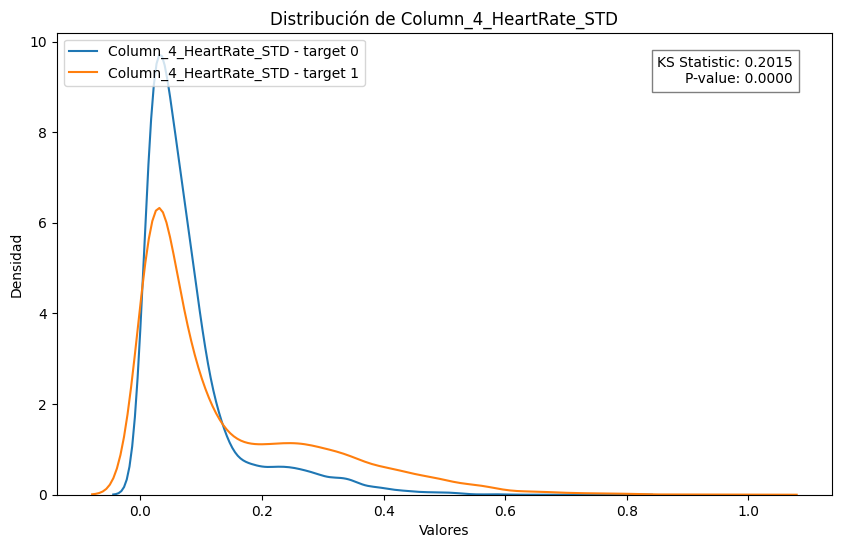

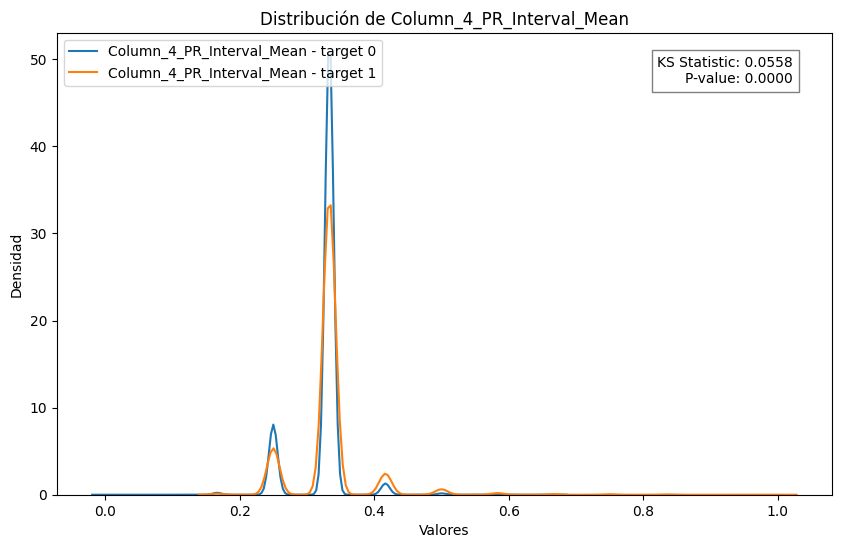

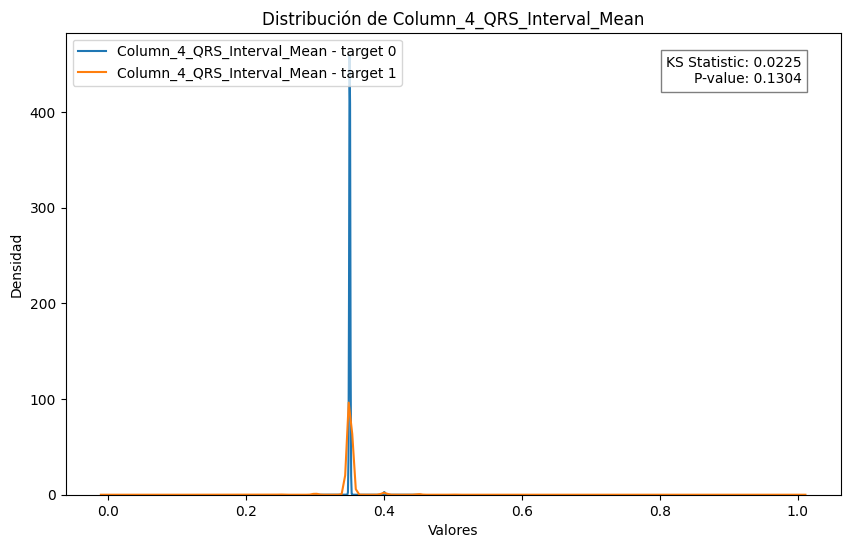

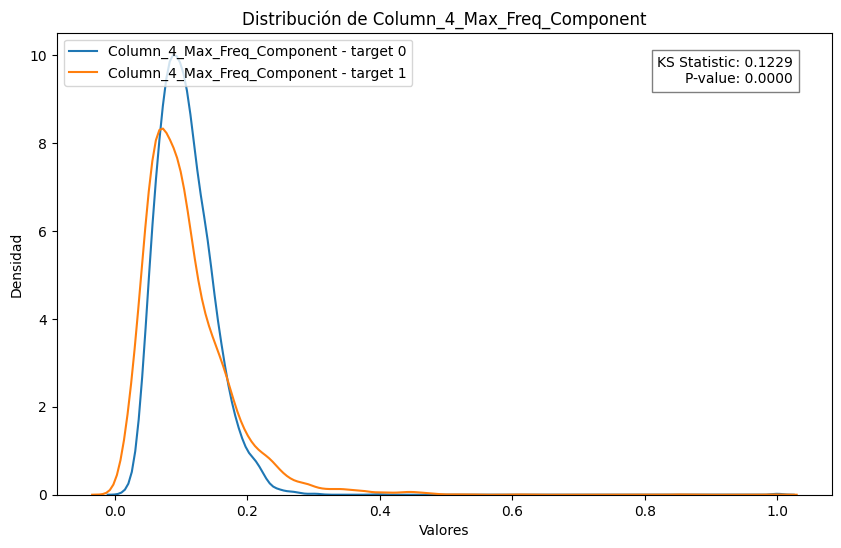

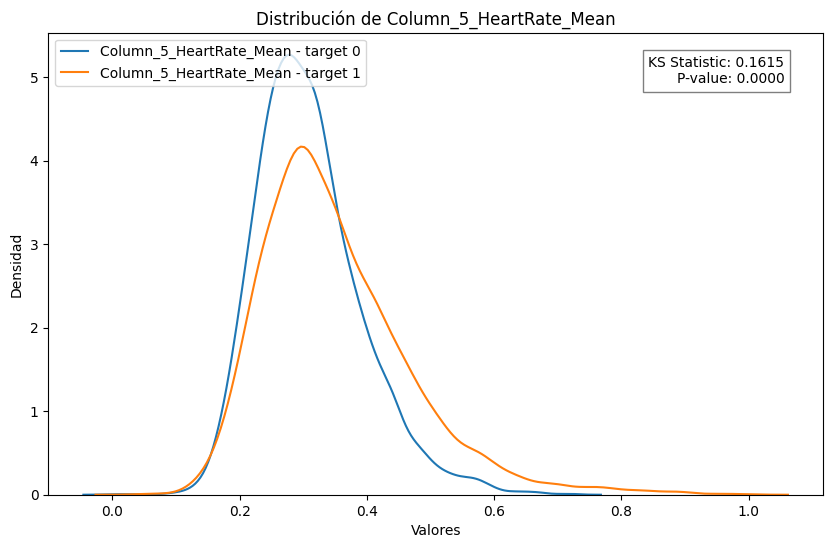

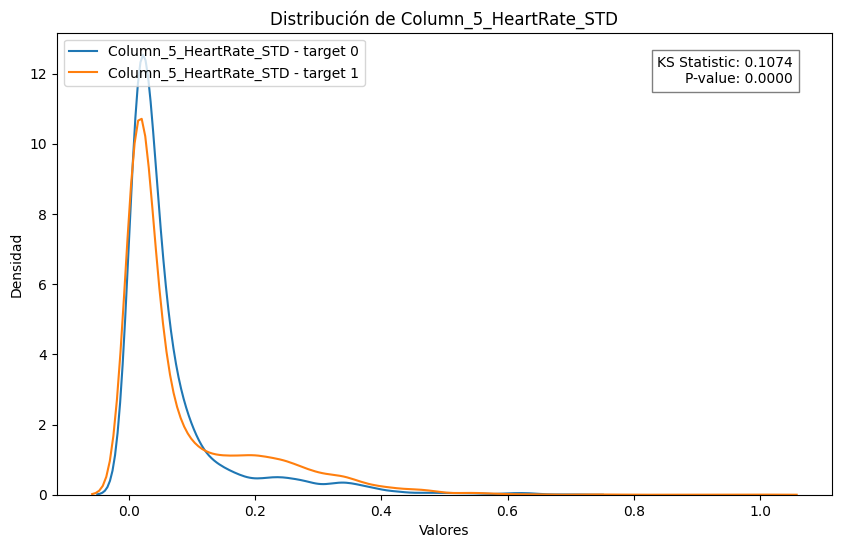

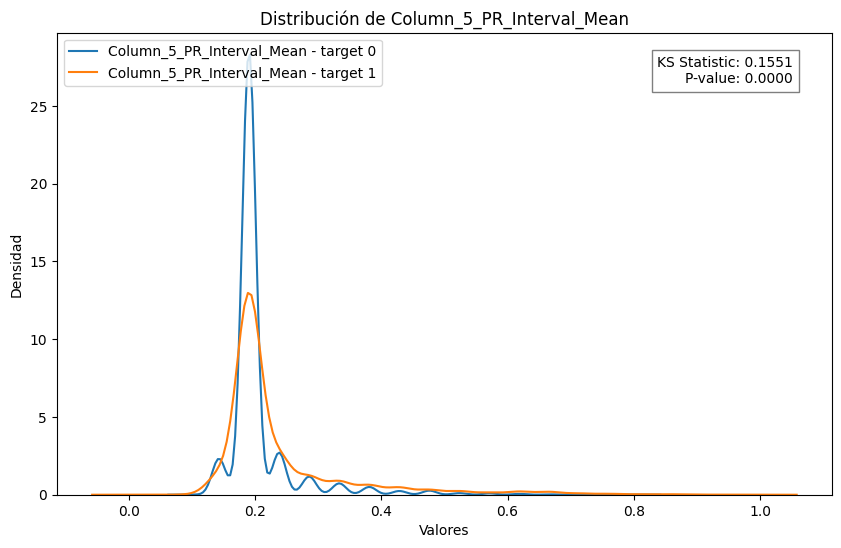

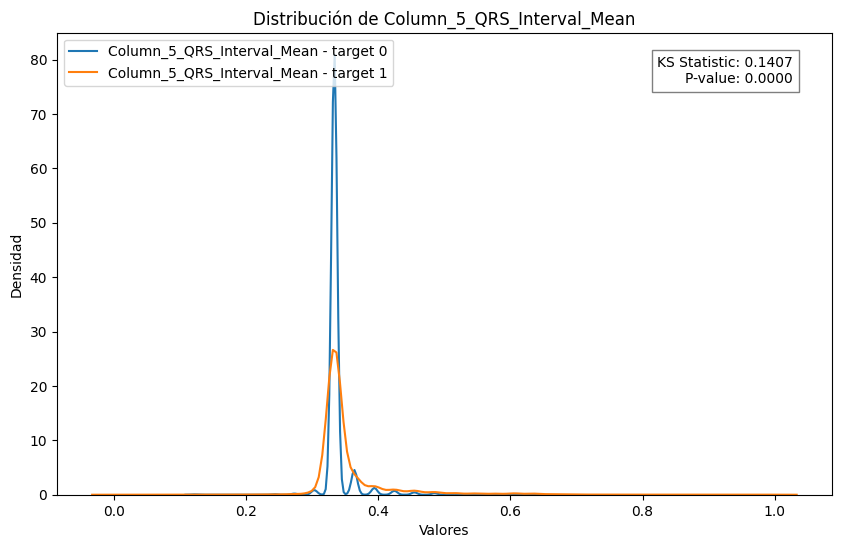

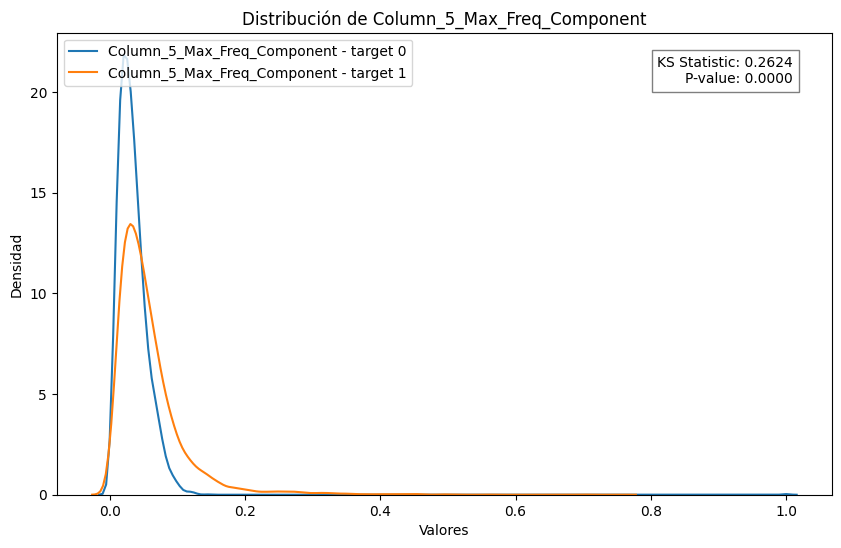

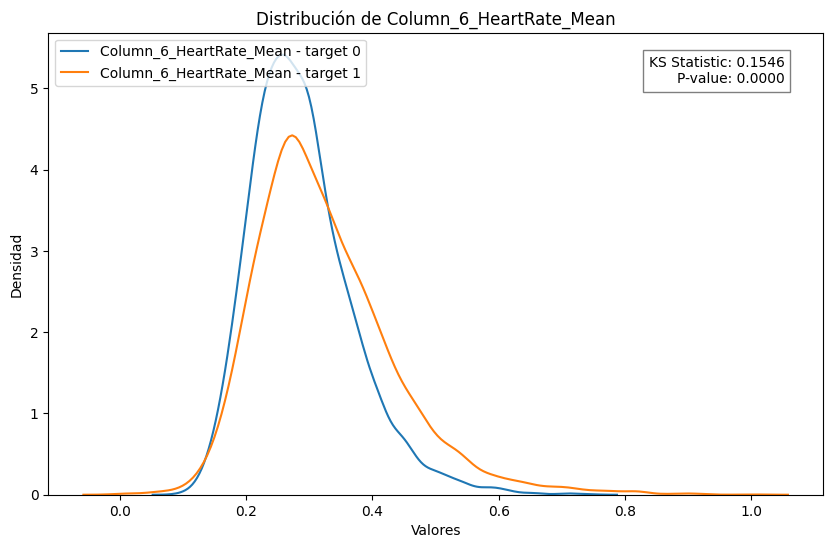

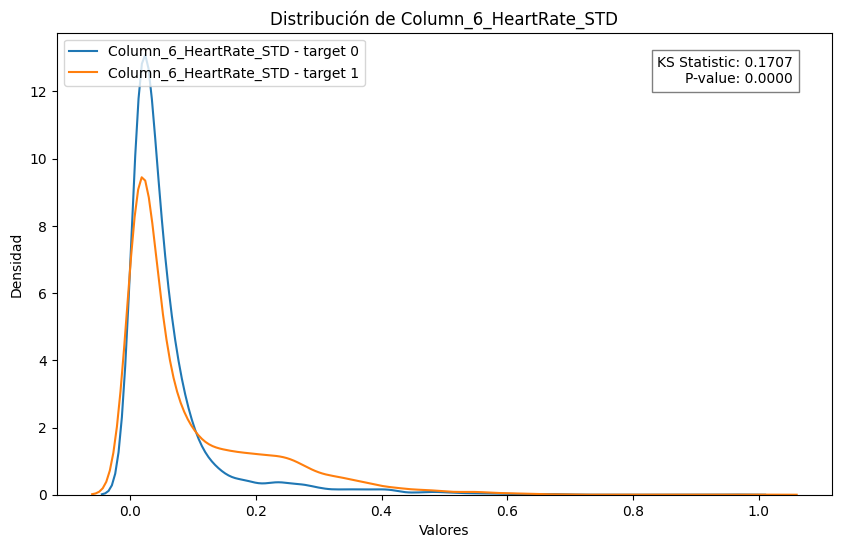

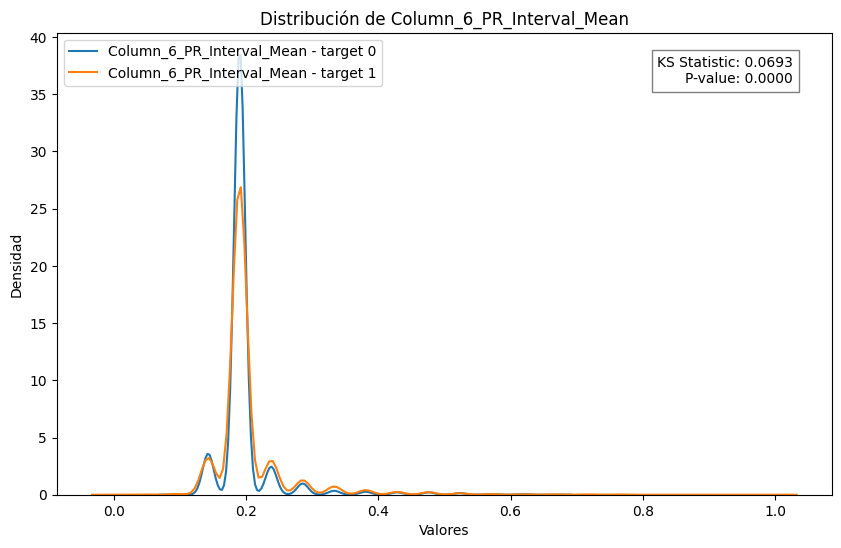

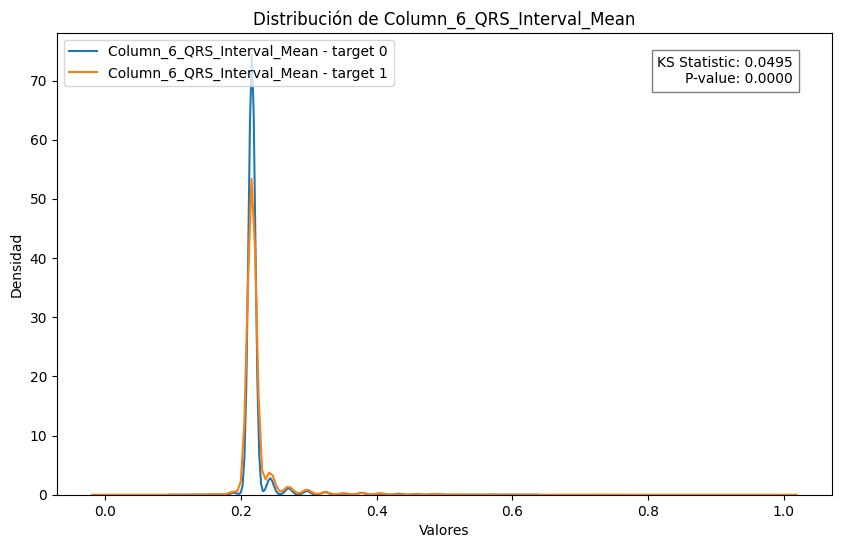

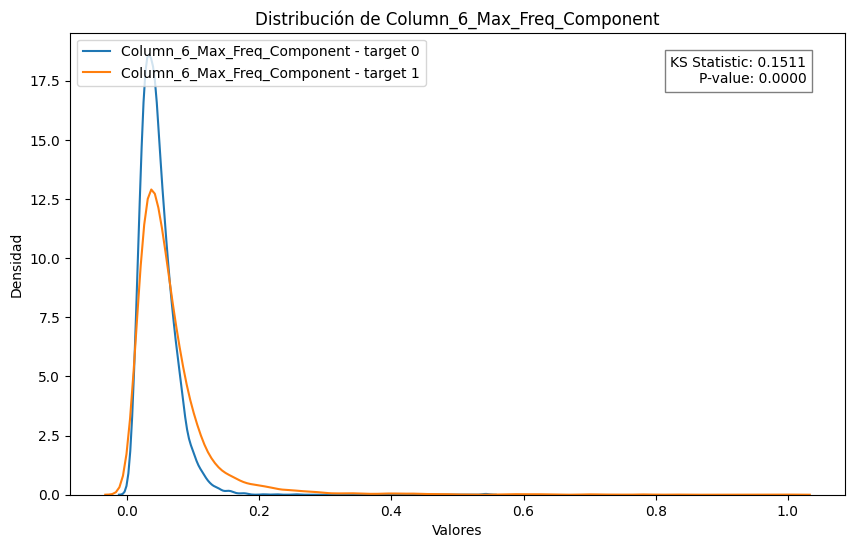

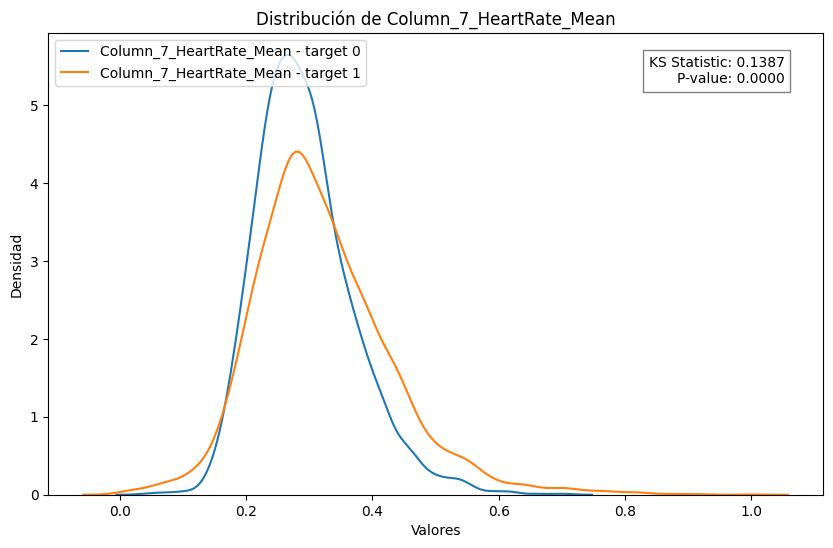

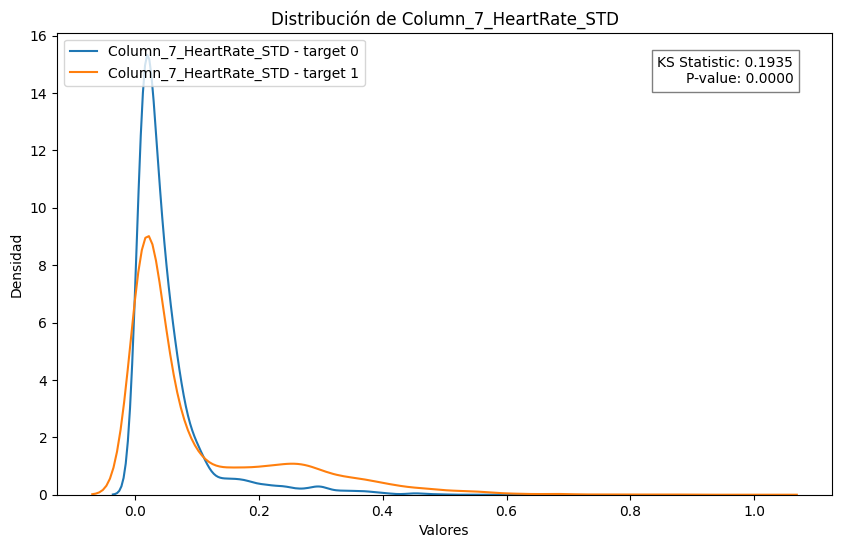

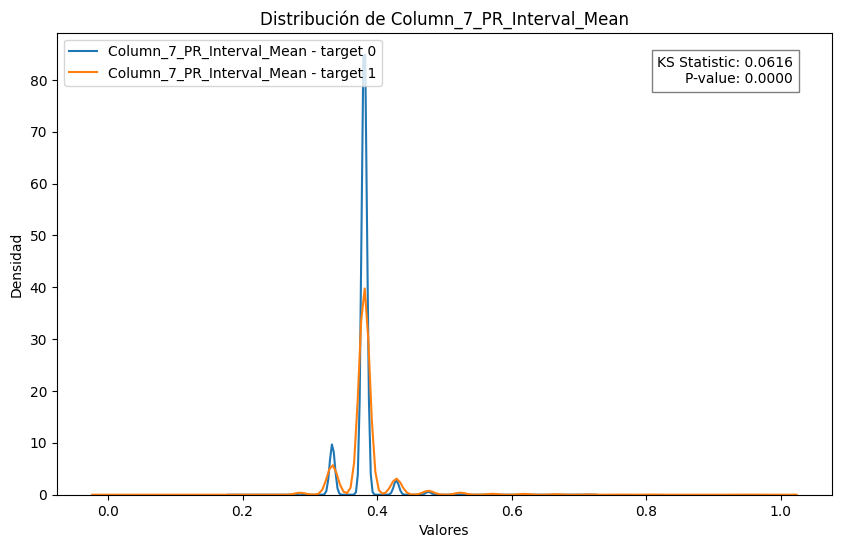

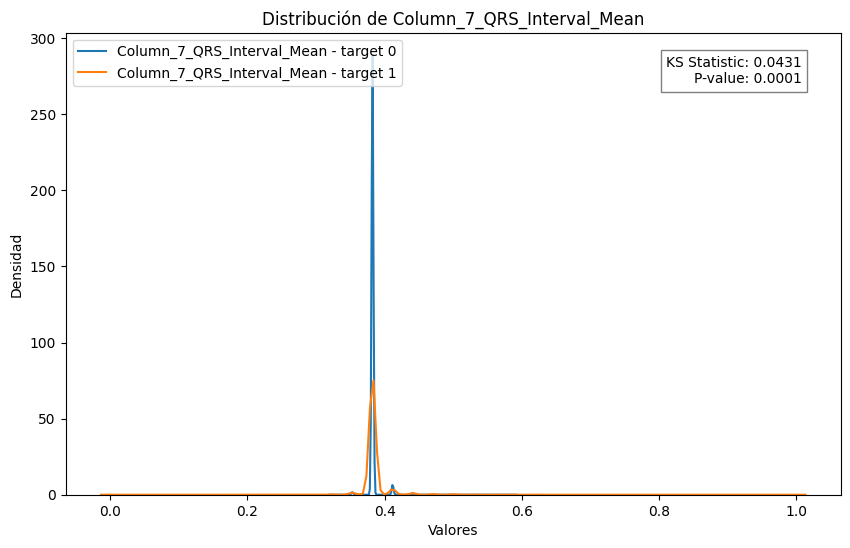

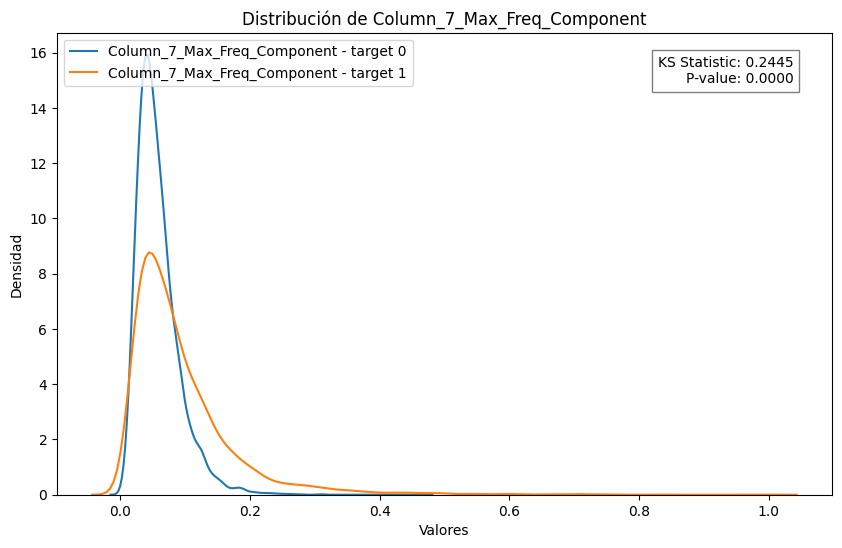

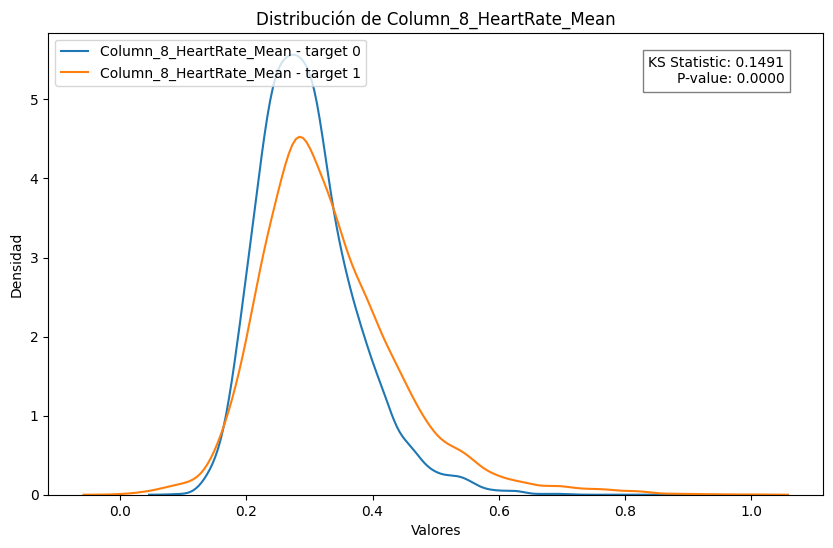

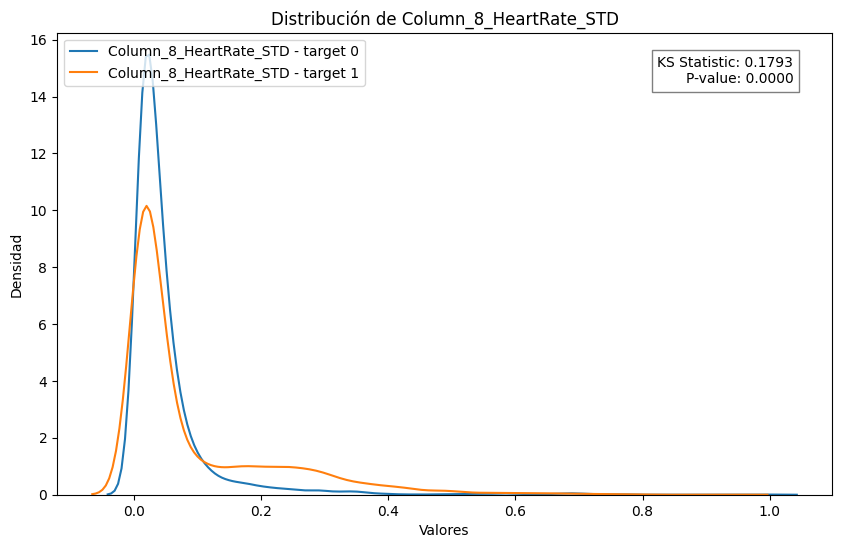

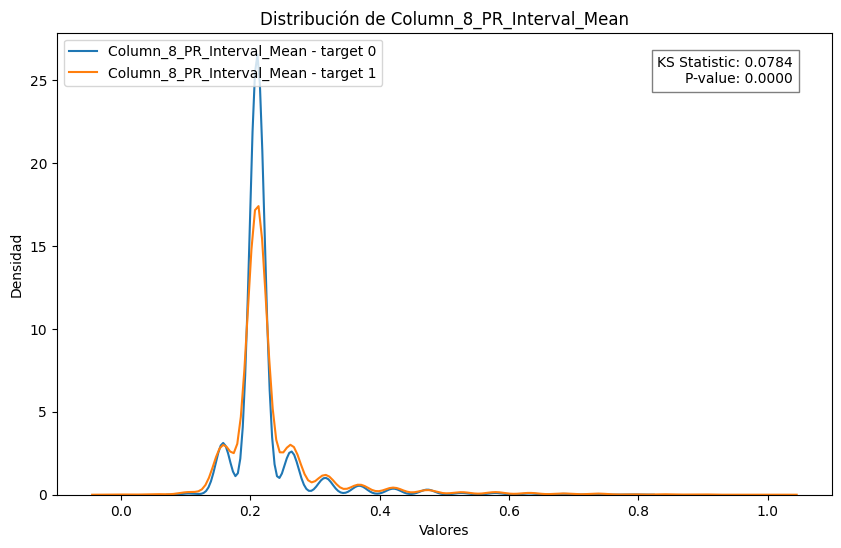

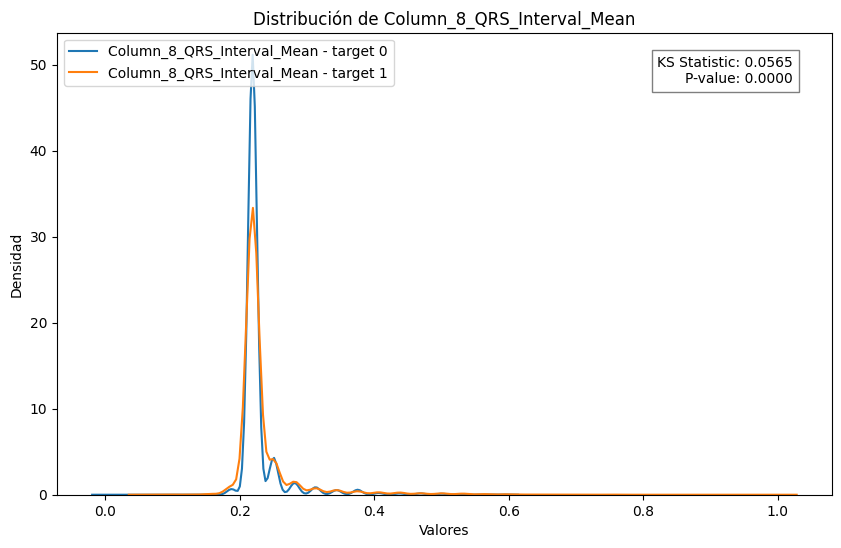

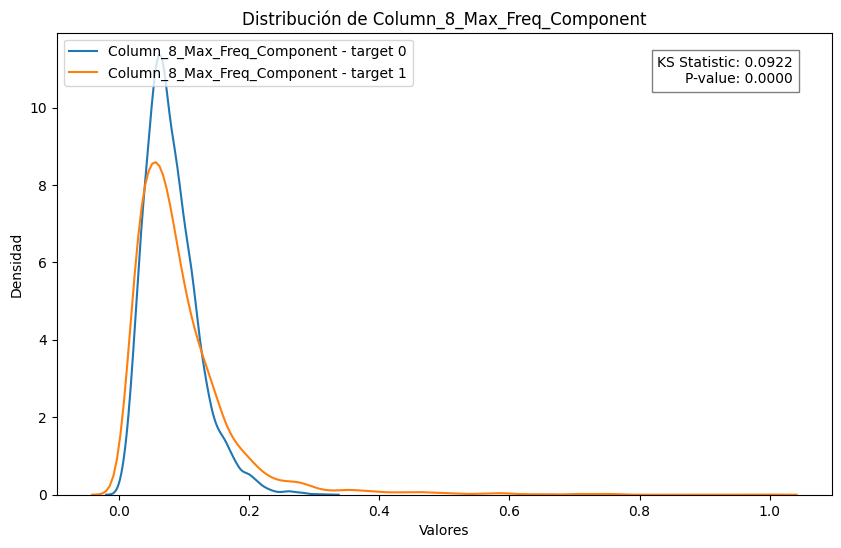

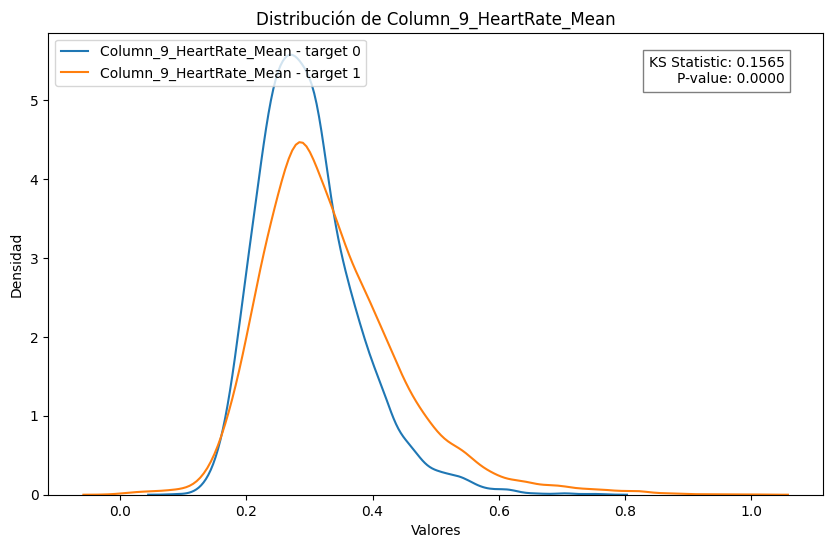

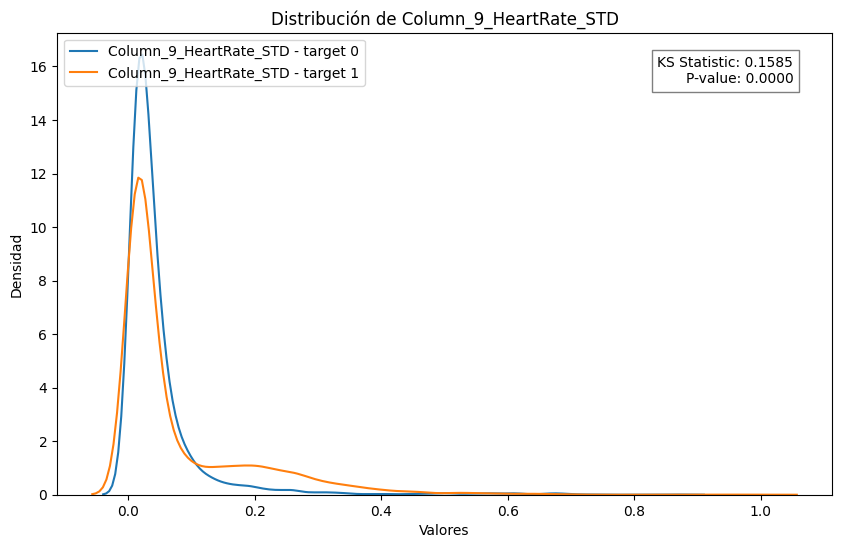

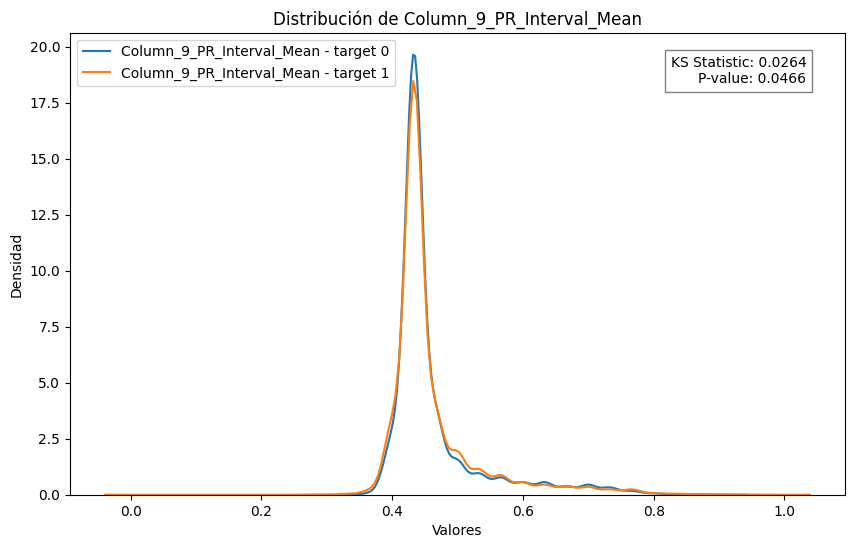

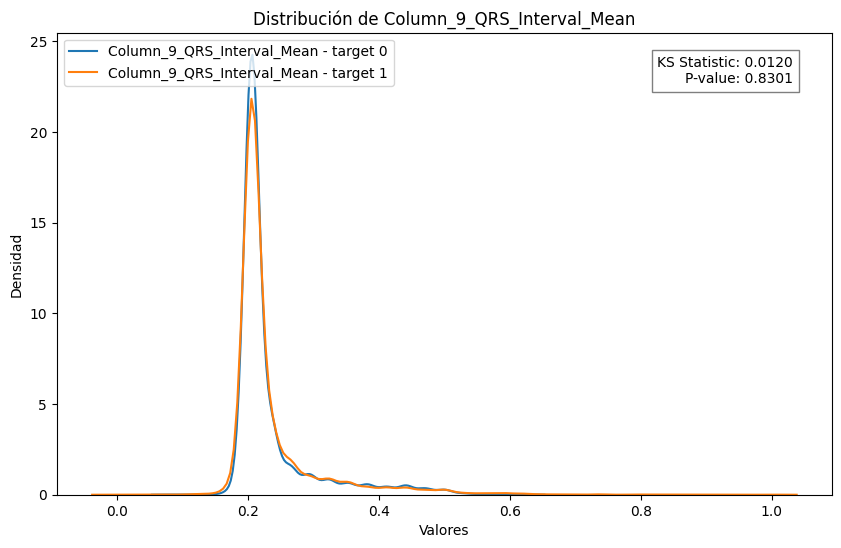

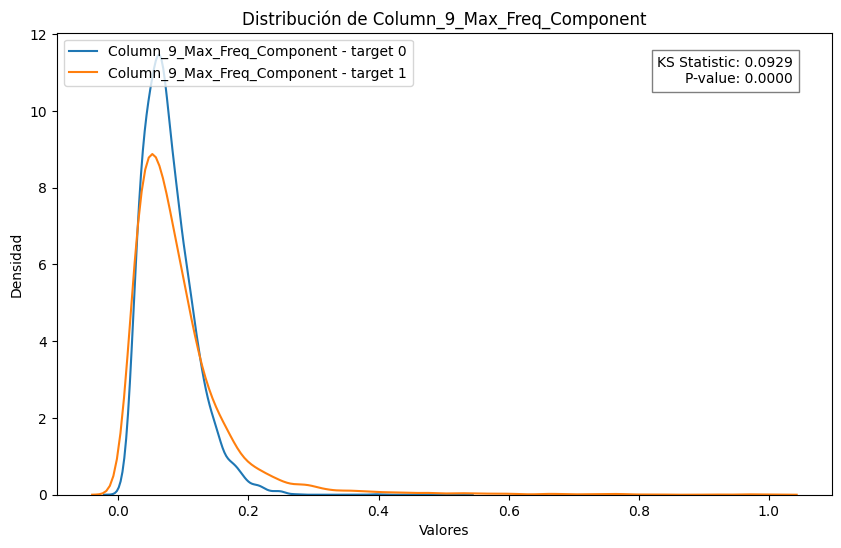

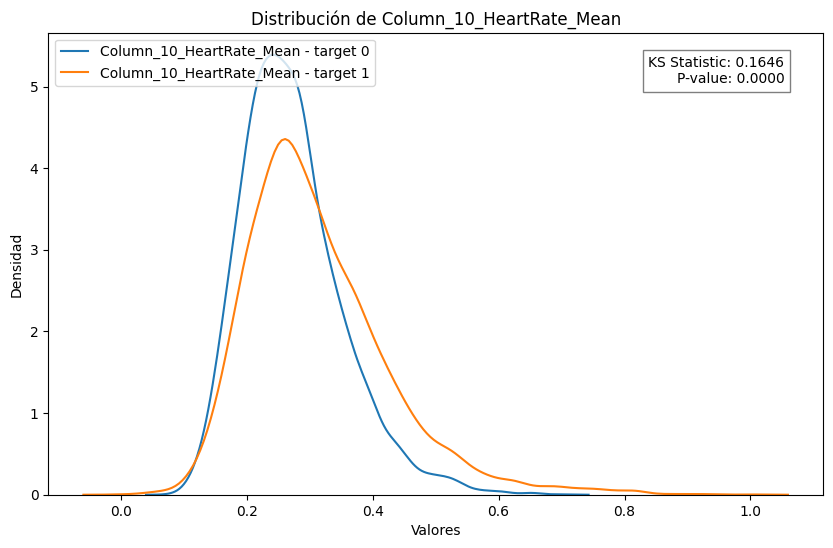

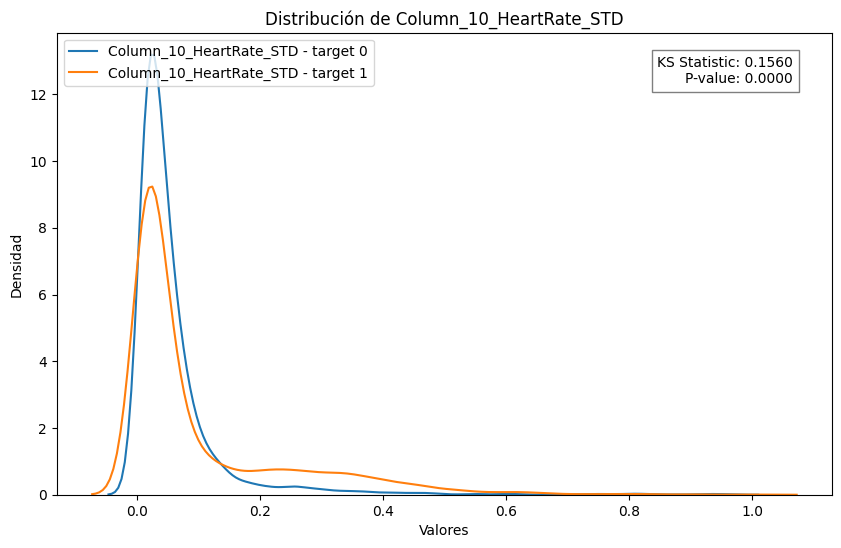

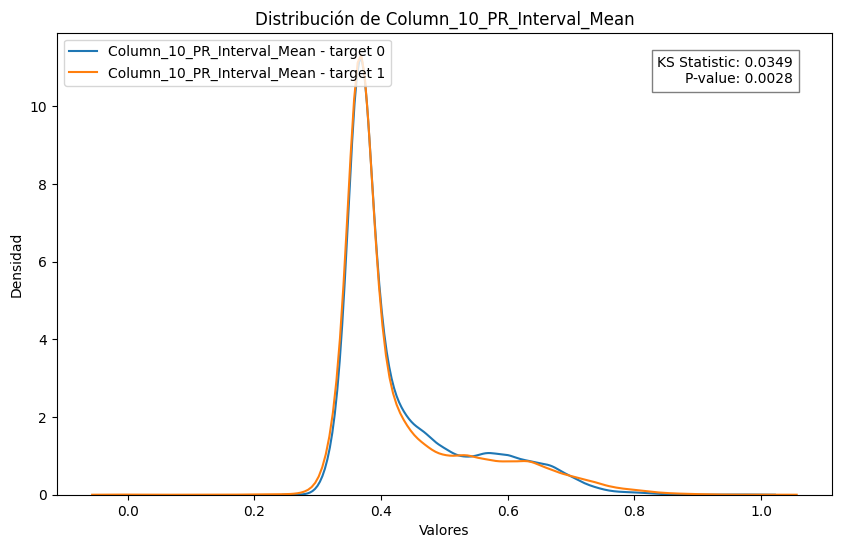

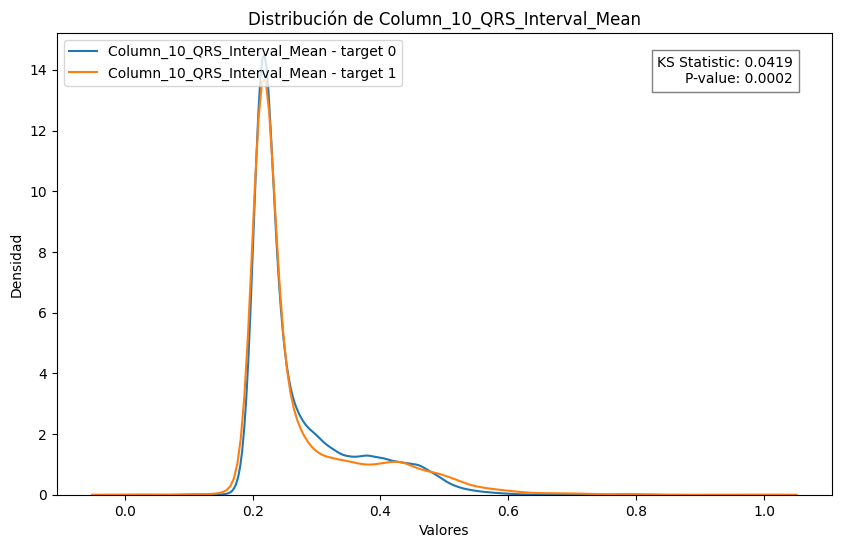

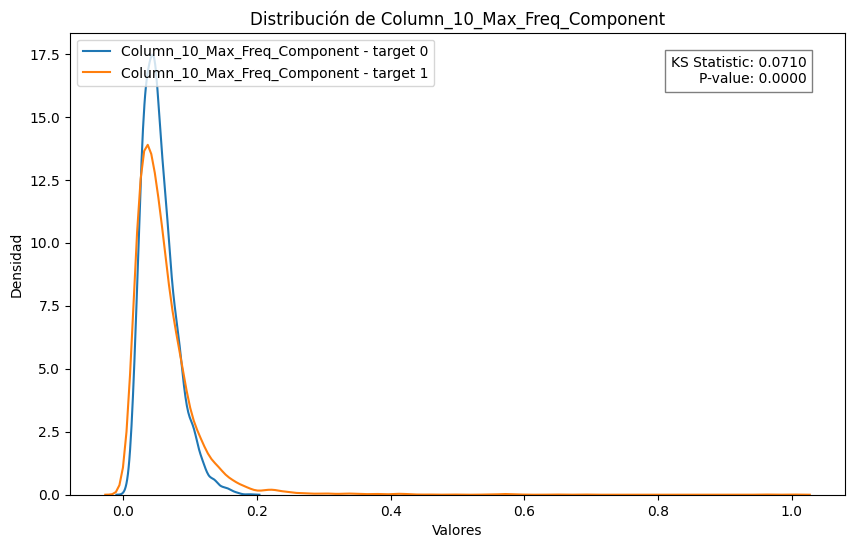

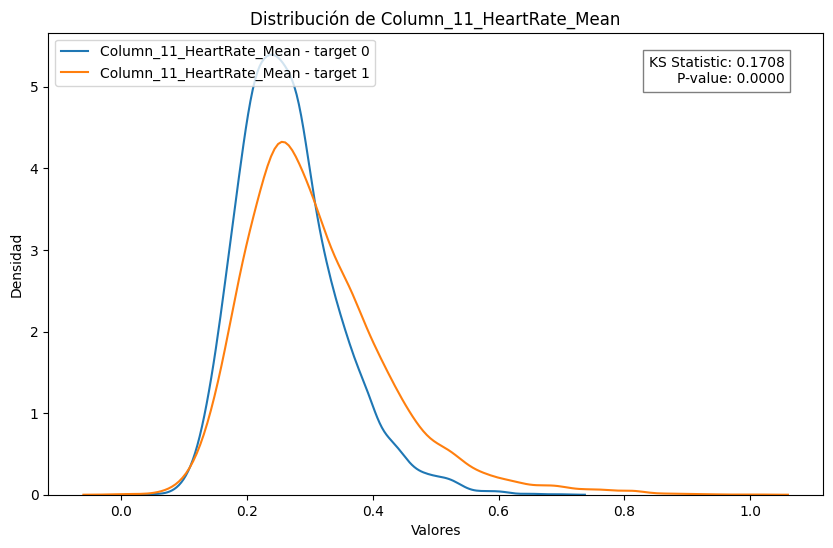

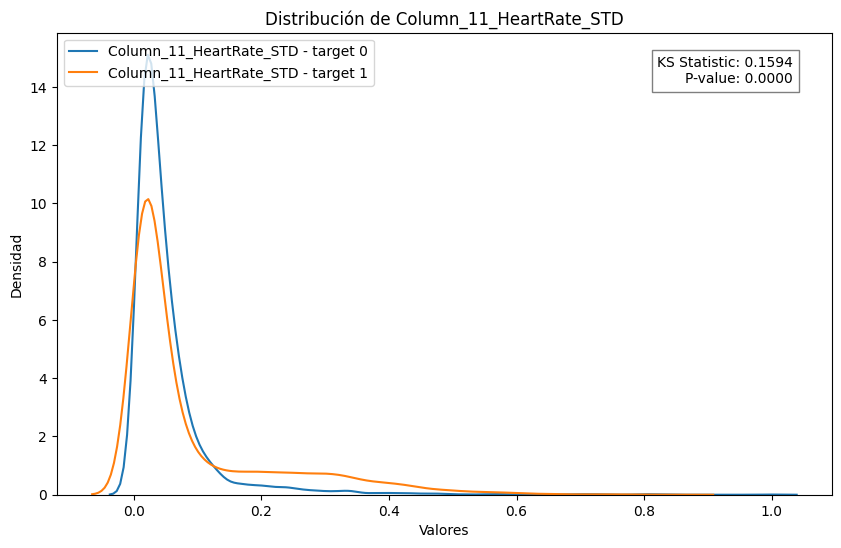

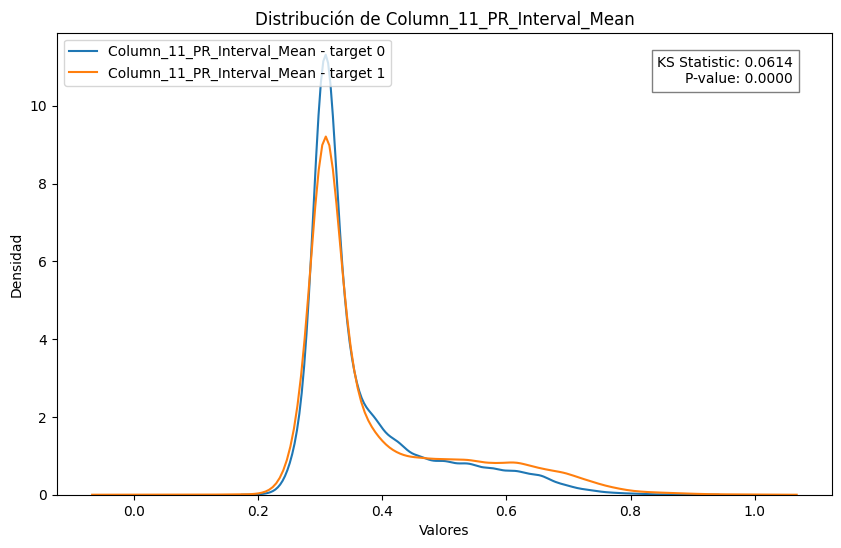

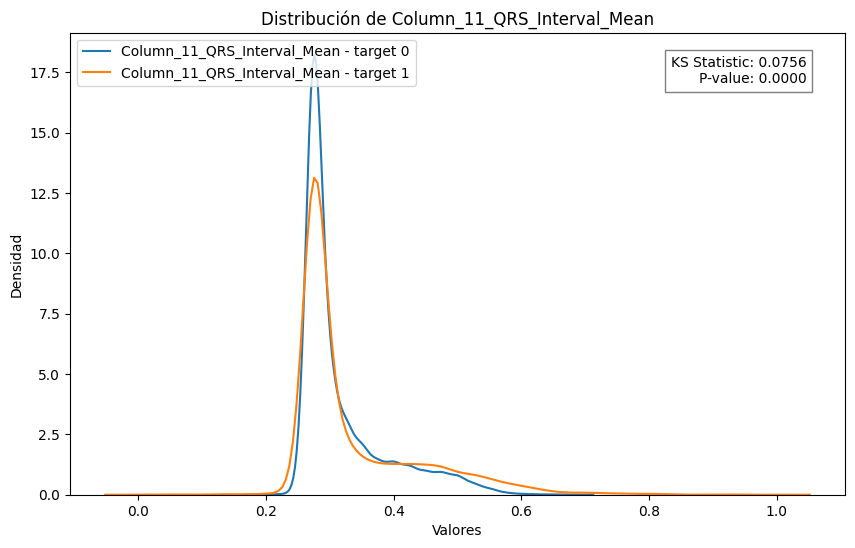

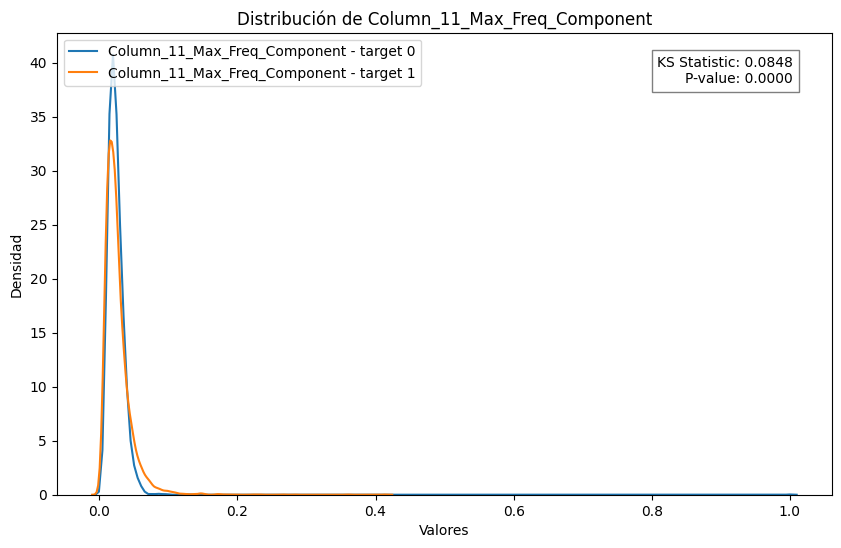

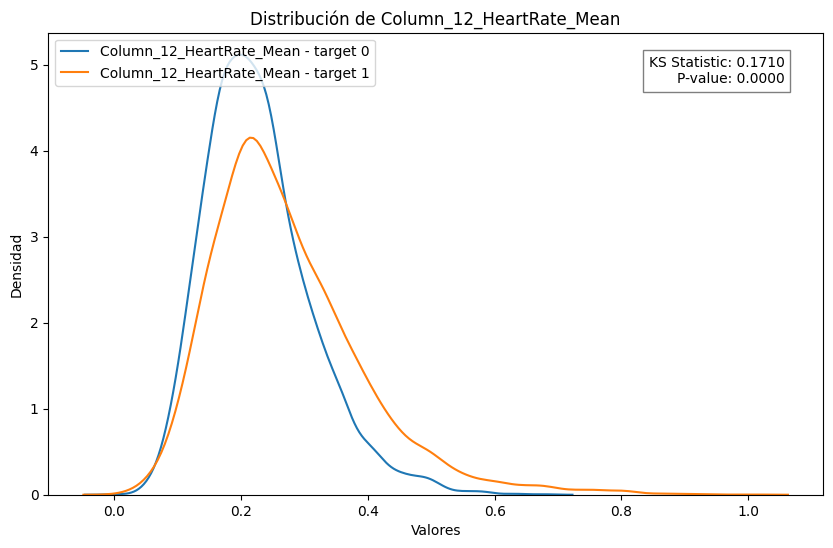

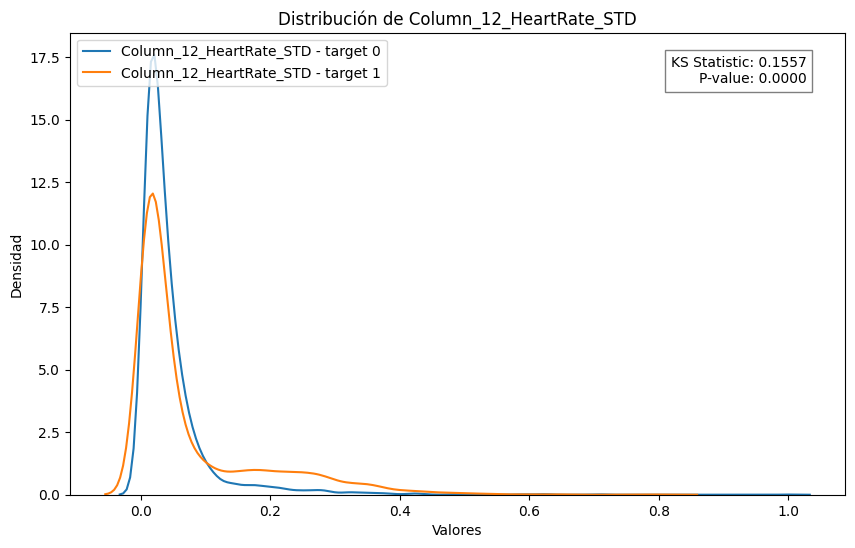

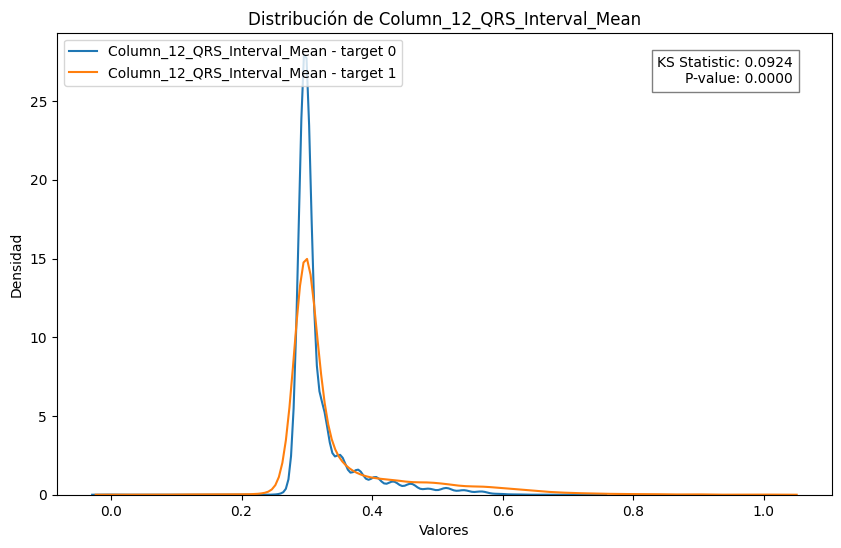

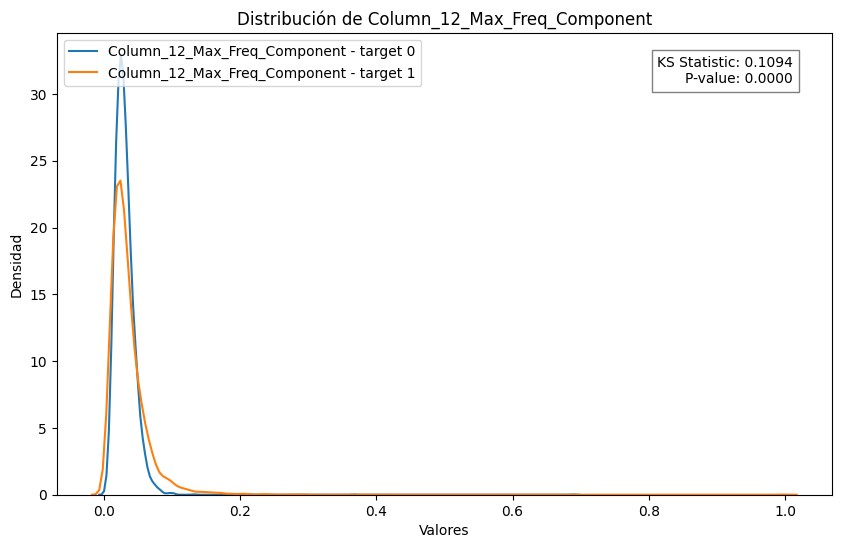

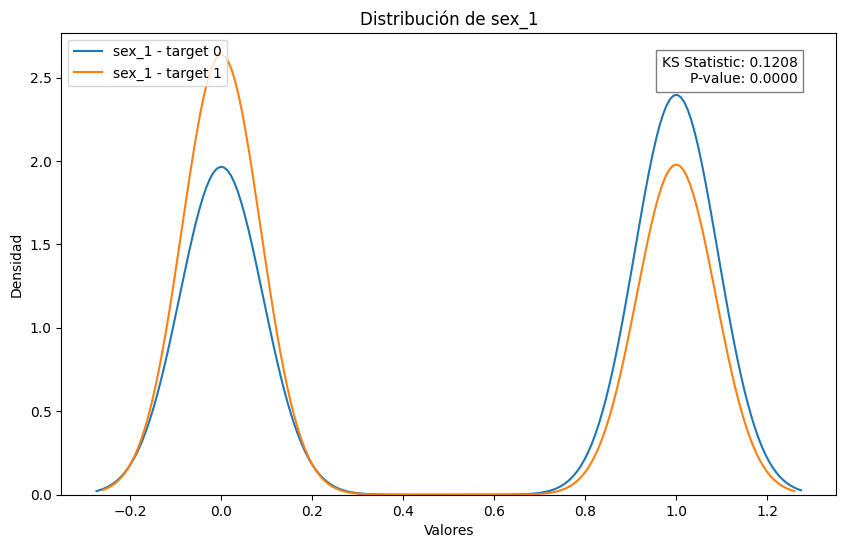

In [34]:
for column in X_train.columns:
    plt.figure(figsize=(10, 6))
    
    sns.kdeplot(processed_df.loc[processed_df[target] == 0, column], label=f"{column} - target 0")
    sns.kdeplot(processed_df.loc[processed_df[target] == 1, column], label=f"{column} - target 1")
    
    # Calcular la prueba KS
    data_target0 = processed_df.loc[processed_df[target] == 0, column]
    data_target1 = processed_df.loc[processed_df[target] == 1, column]
    ks_statistic, p_value = stats.ks_2samp(data_target0, data_target1)
    
    plt.xlabel("Valores")
    plt.ylabel("Densidad")
    plt.title(f"Distribución de {column}")
    
    plt.text(0.95, 0.95, f"KS Statistic: {ks_statistic:.4f}\nP-value: {p_value:.4f}", 
             ha="right", va="top", transform=plt.gca().transAxes, bbox=dict(facecolor="white", alpha=0.5))
    
    plt.legend(loc="upper left")  
    
    plt.show()

## Correlación

In [16]:
corr_df = processed_df.corr().round(2) * 100
corr_df = corr_df.astype(int)

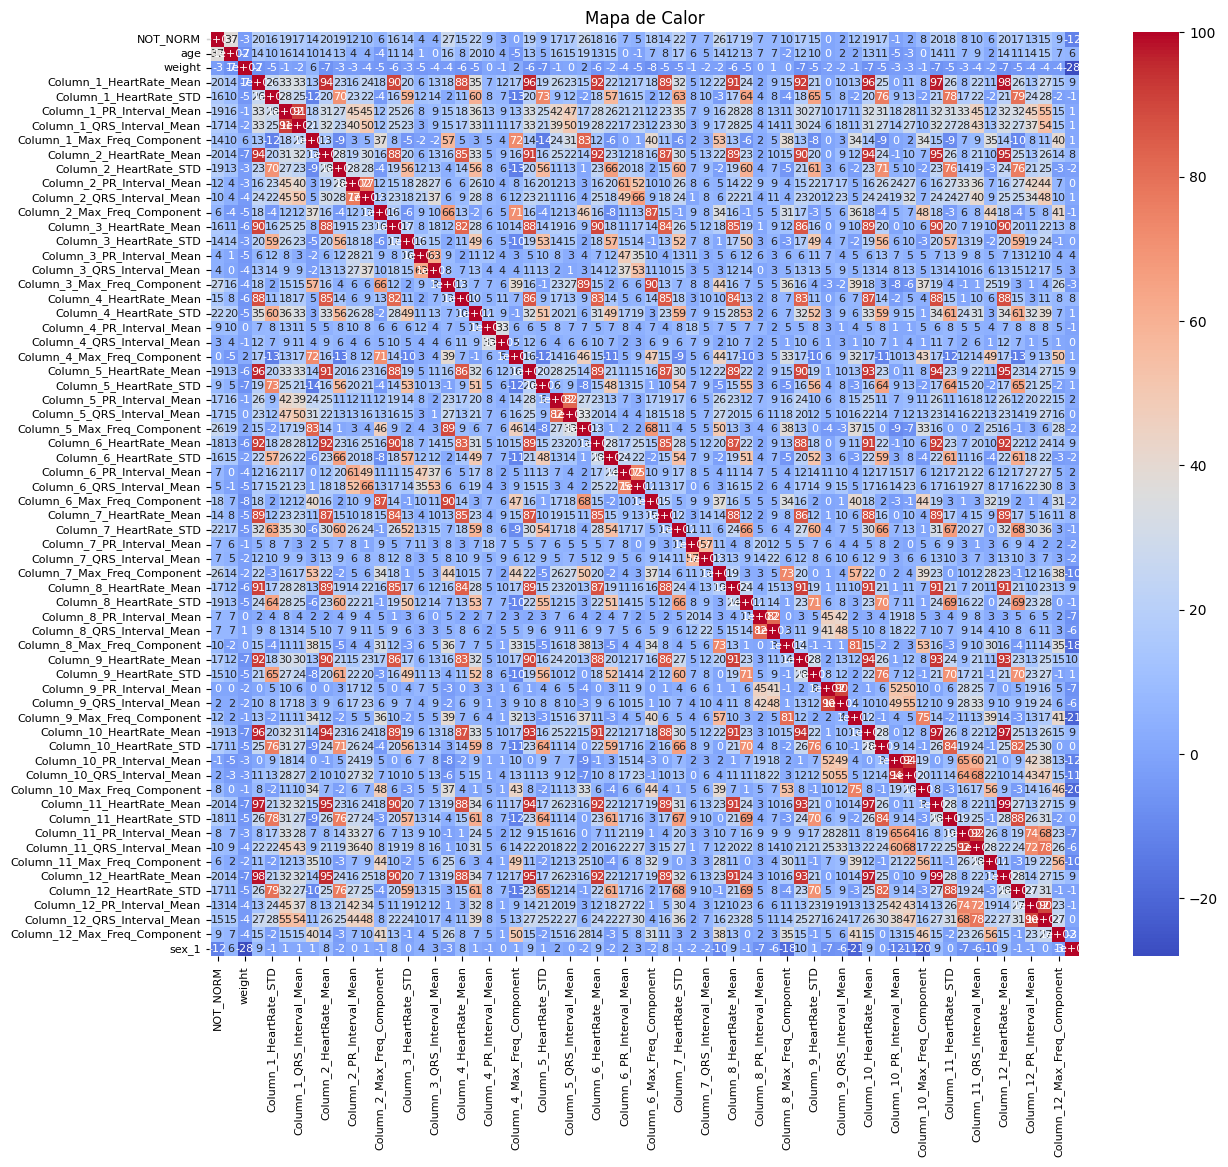

In [34]:
plt.figure(figsize=(14, 12))
ax = sns.heatmap(corr_df, annot=True, cmap="coolwarm", annot_kws={"size": 8})
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
plt.title("Mapa de Calor")
plt.show()

## Modelos base

In [35]:
models_dict = {
    "knn": KNeighborsClassifier(),
    "svc": SVC(probability=True, random_state=0),
    "logistic_regression": LogisticRegression(n_jobs=-1, random_state=0),
    "xgb": XGBClassifier(n_jobs=-1, random_state=0),
}

results_df = evaluate_models(models_dict, X_train, X_test, y_train, y_test)
results_df

model  f1-score-train  std-dev  f1-score-test  roc-auc-test
0                  knn        0.688324   0.0145       0.704727          0.75
1                  svc        0.754028   0.0104       0.787224          0.84
2  logistic_regression        0.744236   0.0100       0.777751          0.83
3                  xgb        0.771230   0.0080       0.799411          0.86

## Selección de características

### Por correlación

In [17]:
target_corr = corr_df[target].abs().sort_values(ascending=False)
target_corr.to_frame().describe()

NOT_NORM
count   64.000000
mean    14.625000
std     13.113061
min      0.000000
25%      7.000000
50%     14.500000
75%     18.250000
max    100.000000

**Seleccionando las características más correlacionadas con la variable objetivo**

In [18]:
 # Conservando el 75% de las features
threshold_target_corr = target_corr.quantile(0.25)

selected_features = target_corr[target_corr >= threshold_target_corr].index.tolist()
selected_features.remove(target)

len(selected_features)

51

**Eliminando características altamente correlacionadas entre sí**

In [19]:
selected_features_df = processed_df[selected_features]
selected_features_corr = selected_features_df.corr().abs()
threshold_feature_corr = 0.8
uncorrelated_features = set(selected_features)

for feature in selected_features:
    if feature in uncorrelated_features:
        highly_corr_features = selected_features_corr[feature][selected_features_corr[feature] > threshold_feature_corr].index.tolist()
        for corr_feature in highly_corr_features:
            if corr_feature != feature:
                uncorrelated_features.discard(corr_feature)

best_features_by_corr = list(uncorrelated_features)

print("Total de features", len(best_features_by_corr))

for indice, feat in enumerate(best_features_by_corr, start=1):
    print(f"{indice}. {feat}", sep="\n")

Total de features 30
1. Column_8_PR_Interval_Mean
2. Column_11_QRS_Interval_Mean
3. Column_2_PR_Interval_Mean
4. Column_7_QRS_Interval_Mean
5. Column_9_Max_Freq_Component
6. Column_12_QRS_Interval_Mean
7. Column_2_QRS_Interval_Mean
8. Column_2_HeartRate_STD
9. Column_7_HeartRate_STD
10. Column_7_PR_Interval_Mean
11. Column_3_Max_Freq_Component
12. Column_4_PR_Interval_Mean
13. Column_1_HeartRate_STD
14. Column_3_HeartRate_STD
15. Column_1_PR_Interval_Mean
16. Column_1_HeartRate_Mean
17. Column_12_Max_Freq_Component
18. Column_8_HeartRate_STD
19. Column_4_HeartRate_STD
20. Column_5_PR_Interval_Mean
21. Column_6_PR_Interval_Mean
22. Column_11_HeartRate_STD
23. Column_9_HeartRate_STD
24. Column_5_HeartRate_STD
25. Column_7_Max_Freq_Component
26. Column_6_HeartRate_STD
27. Column_1_Max_Freq_Component
28. age
29. Column_10_Max_Freq_Component
30. sex_1


### Selección por RFE

In [12]:
model = LogisticRegression(n_jobs=-1)
best_features_by_rfe = get_best_features_rfecv(X_train, y_train, model, scoring="roc_auc")
print("Total de features", len(best_features_by_rfe))

for indice, feat in enumerate(best_features_by_rfe, start=1):
    print(f"{indice}. {feat}", sep="\n")

Total de features 46
1. age
2. weight
3. Column_1_HeartRate_Mean
4. Column_1_HeartRate_STD
5. Column_1_PR_Interval_Mean
6. Column_1_QRS_Interval_Mean
7. Column_1_Max_Freq_Component
8. Column_2_HeartRate_STD
9. Column_2_PR_Interval_Mean
10. Column_2_QRS_Interval_Mean
11. Column_2_Max_Freq_Component
12. Column_3_PR_Interval_Mean
13. Column_3_Max_Freq_Component
14. Column_4_HeartRate_Mean
15. Column_4_HeartRate_STD
16. Column_4_PR_Interval_Mean
17. Column_4_QRS_Interval_Mean
18. Column_4_Max_Freq_Component
19. Column_5_HeartRate_Mean
20. Column_5_HeartRate_STD
21. Column_5_PR_Interval_Mean
22. Column_5_QRS_Interval_Mean
23. Column_5_Max_Freq_Component
24. Column_6_HeartRate_Mean
25. Column_6_PR_Interval_Mean
26. Column_6_Max_Freq_Component
27. Column_7_HeartRate_Mean
28. Column_7_HeartRate_STD
29. Column_7_PR_Interval_Mean
30. Column_7_Max_Freq_Component
31. Column_8_HeartRate_Mean
32. Column_8_HeartRate_STD
33. Column_8_PR_Interval_Mean
34. Column_8_Max_Freq_Component
35. Column_9_HeartR

### Selección por XGBoost

In [40]:
model = LogisticRegression(n_jobs=-1)
results_lr = modeling_by_xgb_importance(
    model_name="logistic regression", model=model, x_train=X_train,
    y_train=y_train, x_test=X_test, y_test=y_test
)

results_lr.head()

Models         Id  No_features   ROC  ROC_AUC    F1  Recall  \
0  logistic regression    model_1           63  0.74     0.83  78.0    79.0   
1  logistic regression   model_64           63  0.74     0.83  78.0    79.0   
2  logistic regression  model_127           63  0.74     0.83  78.0    79.0   
3  logistic regression  model_190           63  0.74     0.83  78.0    79.0   
4  logistic regression  model_253           63  0.74     0.83  78.0    79.0   

   Accuracy  Brier Importance_type  \
0      75.0   25.0      total_gain   
1      75.0   25.0     total_cover   
2      75.0   25.0          weight   
3      75.0   25.0            gain   
4      75.0   25.0           cover   

                                       Best_features  
0  Column_7_QRS_Interval_Mean,Column_6_QRS_Interv...  
1  Column_6_PR_Interval_Mean,Column_3_QRS_Interva...  
2  Column_6_QRS_Interval_Mean,Column_7_QRS_Interv...  
3  Column_9_QRS_Interval_Mean,Column_2_QRS_Interv...  
4  Column_4_HeartRate_Mean,Column_6_PR_Interval_M...

In [41]:
results_lr[results_lr["ROC_AUC"] >= 0.83].tail()

Models         Id  No_features   ROC  ROC_AUC    F1  Recall  \
195  logistic regression   model_46           18  0.74     0.83  78.0    79.0   
196  logistic regression  model_235           18  0.74     0.83  78.0    79.0   
197  logistic regression   model_47           17  0.74     0.83  78.0    79.0   
198  logistic regression  model_236           17  0.74     0.83  78.0    79.0   
199  logistic regression   model_51           13  0.74     0.83  78.0    79.0   

     Accuracy  Brier Importance_type  \
195      75.0   25.0      total_gain   
196      75.0   25.0            gain   
197      74.0   26.0      total_gain   
198      75.0   25.0            gain   
199      75.0   25.0      total_gain   

                                         Best_features  
195  Column_6_Max_Freq_Component,Column_8_HeartRate...  
196  Column_4_HeartRate_STD,Column_5_Max_Freq_Compo...  
197  Column_8_HeartRate_STD,Column_1_Max_Freq_Compo...  
198  Column_5_Max_Freq_Component,Column_2_HeartRate...  
199  Column_7_HeartRate_STD,Column_4_HeartRate_STD,...

In [42]:
best_feats_str = results_lr.loc[results_lr["Id"] == "model_51", "Best_features"].iloc[0]
best_features_by_xgb_lr =  best_feats_str.split(",")
len(best_features_by_xgb_lr)

13

In [43]:
model = XGBClassifier(n_jobs=-1)
results_xgb = modeling_by_xgb_importance(
    model_name="xgb", model=model, x_train=X_train,
    y_train=y_train, x_test=X_test, y_test=y_test
)

results_xgb.head()

Models         Id  No_features   ROC  ROC_AUC    F1  Recall  Accuracy  \
0    xgb   model_66           61  0.78     0.86  81.0    81.0      78.0   
1    xgb  model_257           59  0.78     0.86  81.0    81.0      78.0   
2    xgb    model_7           57  0.78     0.86  81.0    81.0      78.0   
3    xgb  model_133           57  0.78     0.86  81.0    81.0      78.0   
4    xgb    model_9           55  0.78     0.86  81.0    81.0      78.0   

   Brier Importance_type                                      Best_features  
0   22.0     total_cover  Column_5_PR_Interval_Mean,Column_12_HeartRate_...  
1   22.0           cover  Column_12_HeartRate_Mean,Column_6_Max_Freq_Com...  
2   22.0      total_gain  Column_9_QRS_Interval_Mean,Column_6_PR_Interva...  
3   22.0          weight  Column_6_PR_Interval_Mean,Column_4_PR_Interval...  
4   22.0      total_gain  Column_3_PR_Interval_Mean,Column_4_PR_Interval...

In [44]:
results_xgb[(results_xgb["ROC_AUC"] == 0.86)
            & (results_xgb["F1"] == 81.0)]

Models         Id  No_features   ROC  ROC_AUC    F1  Recall  Accuracy  \
0     xgb   model_66           61  0.78     0.86  81.0    81.0      78.0   
1     xgb  model_257           59  0.78     0.86  81.0    81.0      78.0   
2     xgb    model_7           57  0.78     0.86  81.0    81.0      78.0   
3     xgb  model_133           57  0.78     0.86  81.0    81.0      78.0   
4     xgb    model_9           55  0.78     0.86  81.0    81.0      78.0   
5     xgb  model_261           55  0.78     0.86  81.0    81.0      78.0   
6     xgb  model_139           51  0.78     0.86  81.0    81.0      78.0   
7     xgb  model_208           45  0.78     0.86  81.0    80.0      78.0   
8     xgb  model_209           44  0.78     0.86  81.0    81.0      78.0   
9     xgb  model_152           38  0.78     0.86  81.0    80.0      78.0   
10    xgb   model_91           36  0.78     0.86  81.0    81.0      78.0   
11    xgb  model_231           22  0.78     0.86  81.0    81.0      78.0   

    Brier Importance_type                                      Best_features  
0    22.0     total_cover  Column_5_PR_Interval_Mean,Column_12_HeartRate_...  
1    22.0           cover  Column_12_HeartRate_Mean,Column_6_Max_Freq_Com...  
2    22.0      total_gain  Column_9_QRS_Interval_Mean,Column_6_PR_Interva...  
3    22.0          weight  Column_6_PR_Interval_Mean,Column_4_PR_Interval...  
4    22.0      total_gain  Column_3_PR_Interval_Mean,Column_4_PR_Interval...  
5    22.0           cover  Column_12_PR_Interval_Mean,Column_11_PR_Interv...  
6    22.0          weight  Column_11_HeartRate_Mean,Column_12_HeartRate_M...  
7    22.0            gain  Column_6_Max_Freq_Component,Column_6_PR_Interv...  
8    22.0            gain  Column_6_PR_Interval_Mean,Column_11_PR_Interva...  
9    22.0          weight  Column_12_PR_Interval_Mean,sex_1,Column_11_Hea...  
10   22.0     total_cover  Column_8_HeartRate_Mean,Column_4_PR_Interval_M...  
11   22.0            gain  Column_5_PR_Interval_Mean,Column_7_PR_Interval...

In [45]:
best_feats_str = results_lr.loc[results_lr["Id"] == "model_208", "Best_features"].iloc[0]
best_features_by_xgb_xgb =  best_feats_str.split(",")
len(best_features_by_xgb_xgb)

45

## Logistic Regression

### Top features

In [46]:
features_dict = {
    "corr": best_features_by_corr,
    "rfc": best_features_by_rfe,
    "xgb-lr": best_features_by_xgb_lr,
    "xgb-xgb": best_features_by_xgb_xgb
}

model = LogisticRegression(n_jobs=-1)

results_list = []
for score_type, top_features in features_dict.items():
    results =  train_classifier_model(
        X_train[top_features], X_test[top_features],
        y_train, y_test, model=model, verbose=False
    )
    _, _, f1_mean_score_train, std_dev_train, f1_score_test, roc_auc_test  = results

    results_list.append([
        score_type, f1_mean_score_train, std_dev_train, f1_score_test, roc_auc_test])

pd.DataFrame(results_list, columns=[
    "score_type", "f1-score-train", "std-dev", "f1-score-test", "roc-auc"])

score_type  f1-score-train  std-dev  f1-score-test  roc-auc
0       corr        0.732889   0.0101       0.767831     0.82
1        rfc        0.745059   0.0097       0.778072     0.83
2     xgb-lr        0.739112   0.0123       0.777831     0.82
3    xgb-xgb        0.744419   0.0106       0.778655     0.83

### GridSearch

In [47]:
param_grid = {
    "penalty": ["l1", "l2", "elasticnet", "none"],
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "solver": ["newton-cg", "newton-cholesky", "lbfgs", "liblinear", "sag", "saga"],
    "max_iter": [100, 200, 300, 400, 500]
}

features_dict = {
    "corr": best_features_by_corr,
    "rfc": best_features_by_rfe,
    "xgb": best_features_by_xgb_lr,
}

model = LogisticRegression(n_jobs=-1)

results_list = []
for score_type, top_features in features_dict.items():
    results =  train_classifier_model(
        X_train[top_features], X_test[top_features], y_train, y_test,
        model=model, param_grid=param_grid, verbose=False
    )
    model, best_params, f1_mean_score_train, std_dev_train, f1_score_test, roc_auc  = results

    results_list.append([score_type, model, best_params, f1_mean_score_train,
                         std_dev_train, f1_score_test, roc_auc])
    
lr_metrics_df = pd.DataFrame(results_list, columns=["score_type", "model", "best_params", "f1-score-train", "std-dev", "f1-score-test", "roc-auc"])
lr_metrics_df

Fitting 3 folds for each of 720 candidates, totalling 2160 fits


/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  

Mejores hiperparámetros encontrados GridSearchCV:
{'C': 10, 'max_iter': 200, 'penalty': 'l1', 'solver': 'saga'}
Fitting 3 folds for each of 720 candidates, totalling 2160 fits


/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  

Mejores hiperparámetros encontrados GridSearchCV:
{'C': 1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}


/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  

Fitting 3 folds for each of 720 candidates, totalling 2160 fits


/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  

Mejores hiperparámetros encontrados GridSearchCV:
{'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}


/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  

score_type                                              model  \
0       corr  LogisticRegression(C=10, max_iter=200, n_jobs=...   
1        rfc  LogisticRegression(C=1, n_jobs=-1, penalty='l1...   
2        xgb  LogisticRegression(C=10, n_jobs=-1, penalty='l...   

                                         best_params  f1-score-train  std-dev  \
0  {'C': 10, 'max_iter': 200, 'penalty': 'l1', 's...        0.734355   0.0141   
1  {'C': 1, 'max_iter': 100, 'penalty': 'l1', 'so...        0.752655   0.0138   
2  {'C': 10, 'max_iter': 100, 'penalty': 'l1', 's...        0.744419   0.0114   

   f1-score-test  roc-auc  
0       0.769342     0.82  
1       0.783071     0.84  
2       0.785628     0.83

## XGB

In [116]:
features_dict = {
    "corr": best_features_by_corr,
    "rfc": best_features_by_rfe,
    "xgb-lr": best_features_by_xgb_lr,
    "xgb-xgb": best_features_by_xgb_xgb
}

model = XGBClassifier(n_jobs=-1)

results_list = []
for score_type, top_features in features_dict.items():
    results =  train_classifier_model(
        X_train[top_features], X_test[top_features],
        y_train, y_test, model=model, verbose=False
    )
    _, _, f1_mean_score_train, std_dev_train, f1_score_test, roc_auc_test  = results

    results_list.append([
        score_type, f1_mean_score_train, std_dev_train, f1_score_test, roc_auc_test])

pd.DataFrame(results_list, columns=[
    "score_type", "f1-score-train", "std-dev", "f1-score-test", "roc-auc"])

score_type  f1-score-train  std-dev  f1-score-test  roc-auc
0       corr        0.760707   0.0078       0.787044     0.84
1        rfc        0.774709   0.0094       0.797278     0.86
2     xgb-lr        0.755218   0.0142       0.795543     0.85
3    xgb-xgb        0.774892   0.0118       0.805766     0.86

### GridSearch

In [119]:
param_grid = {
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 4, 5],
    "min_child_weight": [1, 3, 5],
    "gamma": [0, 0.2, 0.4],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}


features_dict = {
    "corr": best_features_by_corr,
    "rfc": best_features_by_rfe,
    "xgb-lr": best_features_by_xgb_lr,
    "xgb-xgb": best_features_by_xgb_xgb
}

model = XGBClassifier(n_jobs=-1)

results_list = []
for score_type, top_features in features_dict.items():
    results =  train_classifier_model(
        X_train[top_features], X_test[top_features], y_train, y_test,
        model=model, param_grid=param_grid, verbose=False
    )
    model, best_params, f1_mean_score_train, std_dev_train, f1_score_test, roc_auc  = results

    results_list.append([score_type, model, best_params, f1_mean_score_train,
                         std_dev_train, f1_score_test, roc_auc])
    
xgb_metrics_df = pd.DataFrame(results_list, columns=["score_type", "model", "best_params", "f1-score-train", "std-dev", "f1-score-test", "roc-auc"])
xgb_metrics_df

Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Mejores hiperparámetros encontrados GridSearchCV:
{'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.8}
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Mejores hiperparámetros encontrados GridSearchCV:
{'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.8}
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Mejores hiperparámetros encontrados GridSearchCV:
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Mejores hiperparámetros encontrados GridSearchCV:
{'colsample_bytree': 1.0, 'gamma': 0.4, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300, 'sub

score_type                                              model  \
0       corr  XGBClassifier(base_score=None, booster=None, c...   
1        rfc  XGBClassifier(base_score=None, booster=None, c...   
2     xgb-lr  XGBClassifier(base_score=None, booster=None, c...   
3    xgb-xgb  XGBClassifier(base_score=None, booster=None, c...   

                                         best_params  f1-score-train  std-dev  \
0  {'colsample_bytree': 1.0, 'gamma': 0.2, 'learn...        0.769582   0.0085   
1  {'colsample_bytree': 1.0, 'gamma': 0.2, 'learn...        0.777727   0.0042   
2  {'colsample_bytree': 0.8, 'gamma': 0, 'learnin...        0.767478   0.0111   
3  {'colsample_bytree': 1.0, 'gamma': 0.4, 'learn...        0.783950   0.0072   

   f1-score-test  roc-auc  
0       0.796784     0.85  
1       0.806743     0.87  
2       0.804084     0.86  
3       0.809407     0.87

In [120]:
with open("../results/9-Electrocardiograma/xgb_metrics_df.pickle", "wb") as f:
    pickle.dump(xgb_metrics_df, f)

In [126]:
best_df = xgb_metrics_df[xgb_metrics_df["score_type"] == "xgb-xgb"]
best_model = best_df["model"].values[0]
best_features = best_features_by_xgb_xgb

with open("../results/9-Electrocardiograma/best_model.pickle", "wb") as f:
    pickle.dump(best_model, f)

with open("../results/9-Electrocardiograma/best_features.pickle", "wb") as f:
    pickle.dump(best_features, f)

In [121]:
s = ["learning_rate", "n_estimators", "max_depth",
     "min_child_weight", "gamma", "subsample", "colsample_bytree"]

for i in s:
    print(i, ": ", best_model.get_params()[i])

learning_rate :  0.1
n_estimators :  300
max_depth :  3
min_child_weight :  1
gamma :  0.4
subsample :  0.8
colsample_bytree :  1.0


## Predicción sobre nuevos datos

### Obtención de features en test

In [58]:
raw_test_df = pd.read_csv("../data/electrocardiograma/test_e1.csv")
raw_test_df.loc[:, "filename_hr"] = "../data/electrocardiograma/" + raw_test_df["filename_hr"]
# Creando features con neurokit2
get_features_in_parallel(
    raw_test_df, results_filename="resultados_ecg_test.csv",
    errors_filename="error_files_test.csv", num_cores=8
)

### Predicción

In [4]:
raw_test_df = pd.read_csv("../data/electrocardiograma/test_e1.csv")
raw_test_df.loc[:, "filename_hr"] = "../data/electrocardiograma/" + raw_test_df["filename_hr"]
raw_test_df.shape

(6552, 11)

**Uniendo las features creadas con neurokit2**

In [5]:
features_test_df = pd.read_csv("resultados_ecg_test.csv")
features_test_df.shape

(6260, 109)

In [6]:
print("Registros que no se pudieron procesar:", raw_test_df.shape[0] - features_test_df.shape[0])

Registros que no se pudieron procesar: 292


In [7]:
test_df = raw_test_df.merge(features_test_df, on="filename_hr", how="left")
print(test_df.shape)
test_df.head(1)

(6552, 119)


ecg_id  patient_id   age  sex  height  weight  nurse  site      device  \
0   14710     17114.0  58.0    0     NaN     NaN    0.0   0.0  CS100    3   

        recording_date  ... Column_11_Max_Freq_Component  \
0  1995-08-08 13:08:51  ...                   289.793745   

   Column_12_HeartRate_Mean  Column_12_HeartRate_STD  \
0                 70.333659                 0.343971   

   Column_12_PR_Interval_Mean  Column_12_QRS_Interval_Mean  \
0                      0.0004                       0.0002   

   Column_12_QT_Interval_Mean  Column_12_ST_Segment_Mean  \
0                         NaN                        NaN   

   Column_12_T_Wave_Mean  Column_12_HRV_SDNN  Column_12_Max_Freq_Component  
0                    NaN                 NaN                    200.655421  

[1 rows x 119 columns]

In [ ]:
with open("../results/9-Electrocardiograma/numerical_features.pickle", "rb") as f:
    numerical_features = pickle.load(f)

with open("../results/9-Electrocardiograma/categorical_features.pickle", "rb") as f:
    categorical_features = pickle.load(f)

with open("../results/9-Electrocardiograma/preprocessor.pickle", "rb") as f:
    preprocessor = pickle.load(f)

with open("../results/9-Electrocardiograma/best_model.pickle", "rb") as f:
    best_model = pickle.load(f)

with open("../results/9-Electrocardiograma/best_features.pickle", "rb") as f:
    best_features = pickle.load(f)

In [28]:
predictions_df = test_df[["ecg_id"]].copy()

categorical_features = ["sex"]

transformed_X = preprocessor.transform(test_df)
onehot_encoder = preprocessor.named_transformers_["cat"].named_steps["onehot"]
categorical_features_encoded = onehot_encoder.get_feature_names_out(
        input_features=categorical_features)

feature_names =  numerical_features + list(categorical_features_encoded)

X_test_transformed = pd.DataFrame(transformed_X, columns=feature_names)

X_test_transformed.to_pickle("../results/9-Electrocardiograma/X_test_e1_transformed.pickle")

X_test_transformed.head()

age    weight  Column_1_HeartRate_Mean  Column_1_HeartRate_STD  \
0  0.602151  0.292929                -0.049019                0.016052   
1  0.795699  0.292929                -0.053701                0.086539   
2  0.731183  0.292929                 0.140514                0.058012   
3  0.645161  0.292929                -0.012846                0.050514   
4  0.494624  0.292929                -0.010073                0.100600   

   Column_1_PR_Interval_Mean  Column_1_QRS_Interval_Mean  \
0                   0.185185                 2612.603187   
1                   0.185185                 2612.603187   
2                   0.222222                 3135.069279   
3                   0.185185                 2612.603187   
4                   0.185185                 2612.603187   

   Column_1_Max_Freq_Component  Column_2_HeartRate_Mean  \
0                     0.062373                 0.031499   
1                     0.066349                 0.027102   
2                     0.066981                 0.210523   
3                     0.104143                 0.066000   
4                     0.074546                 0.068289   

   Column_2_HeartRate_STD  Column_2_PR_Interval_Mean  ...  \
0                0.012316                   0.391304  ...   
1                0.062805                   0.173913  ...   
2                0.041846                   0.173913  ...   
3                0.034641                   0.173913  ...   
4                0.069297                   0.173913  ...   

   Column_11_HeartRate_STD  Column_11_PR_Interval_Mean  \
0                 0.006628                 8136.364719   
1                 0.035155                 5177.784541   
2                 0.022428                 3698.494453   
3                 0.020461                 8876.009763   
4                 0.040006                 8876.009763   

   Column_11_QRS_Interval_Mean  Column_11_Max_Freq_Component  \
0                        0.425                     -0.000112   
1                        0.325                     -0.000970   
2                        0.275                     -0.001424   
3                        0.500                      0.001573   
4                        0.450                     -0.000577   

   Column_12_HeartRate_Mean  Column_12_HeartRate_STD  \
0                 -0.062441                 0.011981   
1                 -0.067256                 0.067572   
2                  0.130449                 0.042009   
3                 -0.025322                 0.038136   
4                 -0.022777                 0.074858   

   Column_12_PR_Interval_Mean  Column_12_QRS_Interval_Mean  \
0                 6340.830344                  4880.177665   
1                 8152.424728                  5255.553078   
2                 5435.033152                  4504.802252   
3                 5435.033152                  4880.177665   
4                 6340.830344                  4880.177665   

   Column_12_Max_Freq_Component  sex_1  
0                     -0.002509    0.0  
1                     -0.002948    1.0  
2                     -0.003716    1.0  
3                     -0.001648    0.0  
4                     -0.002866    0.0  

[5 rows x 63 columns]

In [138]:
predictions_df["y_prob"] = best_model.predict_proba(X_test_transformed[best_features])[:, 1]
predictions_df.shape

(6552, 2)

In [140]:
filename = "CDD_G24_M2_E1_Cuauhtemoc_Salvador_Bautista_Enciso.csv"
predictions_df.to_csv(filename, index=False)

predictions_df.head()

ecg_id    y_prob
0   14710  0.718386
1    6122  0.735087
2   20616  0.715434
3    7603  0.994237
4    5768  0.803400

## Estabilidad

In [30]:
# Leyendo características ya transformadas
X_train_transformed = pd.read_pickle("../results/9-Electrocardiograma/X_train.pickle")
X_test_transformed = pd.read_pickle("../results/9-Electrocardiograma/X_test.pickle")
# Leyendo target
y_train = pd.read_pickle("../results/9-Electrocardiograma/y_train.pickle")
y_test = pd.read_pickle("../results/9-Electrocardiograma/y_test.pickle")

### PSI

In [31]:
def calculate_psi(expected, actual, buckets=10, axis=0):
    def scale_range(input, min, max):
        input += -(np.min(input))
        input /= np.max(input) / (max - min + 1e-5)
        input += min
        return input
    
    breakpoints = np.linspace(0, 100, buckets + 1)
    
    if axis == 1:
        psi_value = 0
        for i in range(len(expected.T)):
            psi_value += calculate_psi(expected.T[i], actual.T[i], buckets, axis=0)
        return psi_value
    
    expected_percents = np.histogram(scale_range(expected, 0, 100), breakpoints)[0] / len(expected)
    actual_percents = np.histogram(scale_range(actual, 0, 100), breakpoints)[0] / len(actual)
    
    def sub_psi(e_perc, a_perc):
        if a_perc == 0:
            a_perc = 0.0001
        if e_perc == 0:
            e_perc = 0.0001
        value = (e_perc - a_perc) * np.log(e_perc / a_perc)
        return value
    
    psi_value = np.sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(len(expected_percents)))
    
    return round(psi_value, 4)

def interpret_psi(psi_value):
    if psi_value < 0.1:
        return "No hay cambios significativos"
    elif 0.1 <= psi_value < 0.2:
        return "Pequeños cambios"
    else:
        return "Grandes cambios"


psi_results = []
for feat in best_features:
    psi_value = calculate_psi(X_train_transformed[feat], X_test_transformed[feat])
    psi_interpretation = interpret_psi(psi_value)
    psi_results.append({"Feature": feat, "PSI Value": psi_value, "PSI Interpretation": psi_interpretation})

psi_results_df = pd.DataFrame(psi_results)

/tmp/ipykernel_800/552875976.py:27: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  psi_value = np.sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(len(expected_percents)))


In [32]:
psi_results_df["PSI Interpretation"].value_counts().to_frame()

count
PSI Interpretation                  
No hay cambios significativos     23
Grandes cambios                   18
Pequeños cambios                   4

### Desempeño de poder predictivo

**Agregando fecha a los datos de test**

In [37]:
raw_df = pd.read_csv("../data/electrocardiograma/test_e1.csv")
raw_df.head(1)

ecg_id  patient_id   age  sex  height  weight  nurse  site      device  \
0   14710     17114.0  58.0    0     NaN     NaN    0.0   0.0  CS100    3   

        recording_date                filename_hr  
0  1995-08-08 13:08:51  records500/14000/14710_hr

In [45]:
X_test = raw_df[["recording_date"]].merge(X_test, left_index=True, right_index=True, how="right")

In [61]:
# Agregando la target
data = pd.concat([y_test, X_test], axis=1)

En este caso, se aplicaría sobre los datos de validación, pero al no contar con la target, aplicaré la prueba sobre los datos de test obtenidos de split_train_test

In [62]:
data["date"] = pd.to_datetime(data["recording_date"])
data["month"] = data["date"].dt.month
data["year"] = data["date"].dt.year
# Removiendo valores nulos para el análisis
data = data[data["year"].isnull() == False]

In [63]:
data["year"].value_counts().reset_index().sort_values("year")

year  count
16  1985.0      6
14  1986.0     29
12  1987.0     60
9   1988.0     69
8   1989.0     91
3   1990.0    156
5   1991.0    138
2   1992.0    158
6   1993.0    133
0   1994.0    167
4   1995.0    145
1   1996.0    159
7   1997.0    108
10  1998.0     67
11  1999.0     62
13  2000.0     57
15  2001.0     13

In [74]:
from sklearn.feature_selection import SelectKBest, f_classif

target = "NOT_NORM"


restuls_kb = []
for feat in best_features:
    for year in sorted(data["year"].unique()):
        kb = SelectKBest(k=1, score_func=f_classif) # Medición de poder predictivo
        kb.fit(data.loc[data["year"] == year, [feat]], data.loc[data["year"] == year, target])
        score = kb.scores_[0]

        restuls_kb.append({
            "Característica": feat,
            "Año": year,
            "Poder predictivo": score,
            }
        )

kb_results_df = pd.DataFrame(restuls_kb)
kb_results_df

/usr/local/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/usr/local/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/usr/local/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/usr/local/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by z

Característica     Año  Poder predictivo
0    Column_6_Max_Freq_Component  1985.0          1.854034
1    Column_6_Max_Freq_Component  1986.0          1.665273
2    Column_6_Max_Freq_Component  1987.0          3.493123
3    Column_6_Max_Freq_Component  1988.0          4.347165
4    Column_6_Max_Freq_Component  1989.0          1.969711
..                           ...     ...               ...
760                          age  1997.0         24.302568
761                          age  1998.0          5.677549
762                          age  1999.0          3.560904
763                          age  2000.0          7.649947
764                          age  2001.0          3.913046

[765 rows x 3 columns]

In [99]:
kb_results_df = kb_results_df[
    (kb_results_df['Poder predictivo'] != -np.inf)
    & (kb_results_df['Poder predictivo'] != np.inf)
    & (kb_results_df['Poder predictivo'].isnull() == False)]

In [106]:
kb_results_df["Poder predictivo"].describe()

count    759.000000
mean       3.834239
std        4.885232
min        0.000000
25%        0.482047
50%        2.045982
75%        5.535689
max       34.325851
Name: Poder predictivo, dtype: float64

In [107]:
kb_results_df.groupby("Año")["Poder predictivo"].describe()

count       mean       std           min       25%        50%  \
Año                                                                     
1985.0   40.0   0.834911  1.493395  0.000000e+00  0.080887   0.207462   
1986.0   45.0   1.078629  1.207624  2.257418e-04  0.310919   0.677675   
1987.0   45.0   2.400772  3.293920  1.746888e-03  0.203243   0.887252   
1988.0   45.0   2.761105  3.208247  2.410810e-03  0.664863   1.292631   
1989.0   45.0   3.687079  4.315475  7.287018e-04  0.855769   2.364996   
1990.0   45.0  10.336326  7.091747  5.137182e-04  4.715382  10.879679   
1991.0   45.0   4.708846  5.530314  3.427653e-04  0.771319   2.666197   
1992.0   45.0   5.952277  5.330203  2.677818e-02  1.808706   5.689405   
1993.0   45.0   5.657016  5.454924  2.250072e-06  1.634004   4.795515   
1994.0   45.0   4.131271  4.302155  1.891337e-03  1.003376   2.794202   
1995.0   45.0   5.564491  5.543167  8.437895e-02  2.795477   4.456814   
1996.0   45.0   3.323743  5.754473  8.114109e-04  0.201217   1.651284   
1997.0   45.0   6.577017  5.445933  6.454850e-02  2.056215   5.987062   
1998.0   45.0   2.197235  1.880083  4.240246e-03  0.885389   2.141560   
1999.0   45.0   1.538107  1.931786  2.575490e-05  0.110084   0.602390   
2000.0   45.0   1.895886  2.748038  2.300106e-07  0.149635   0.867818   
2001.0   44.0   2.167036  2.249857  1.408510e-02  0.546570   1.267908   

              75%        max  
Año                           
1985.0   0.635415   5.939394  
1986.0   1.295627   6.863783  
1987.0   3.274725  13.690233  
1988.0   4.347165  14.754888  
1989.0   4.056885  19.675962  
1990.0  13.353894  33.566579  
1991.0   7.196782  23.585083  
1992.0   8.454302  30.859063  
1993.0   7.932682  26.290668  
1994.0   5.253381  16.084258  
1995.0   6.293038  30.631641  
1996.0   3.886583  34.325851  
1997.0   9.741282  24.302568  
1998.0   3.140794   8.398424  
1999.0   2.658454   7.010747  
2000.0   1.852762  10.917723  
2001.0   4.047661   9.363960

In [116]:
max_pp_year = kb_results_df.loc[kb_results_df.groupby('Año')['Poder predictivo'].idxmax()]
max_pp_year

Característica     Año  Poder predictivo
612  Column_12_QRS_Interval_Mean  1985.0          5.939394
749                          age  1986.0          6.863783
478  Column_5_Max_Freq_Component  1987.0         13.690233
479  Column_5_Max_Freq_Component  1988.0         14.754888
752                          age  1989.0         19.675962
753                          age  1990.0         33.566579
754                          age  1991.0         23.585083
755                          age  1992.0         30.859063
756                          age  1993.0         26.290668
468       Column_4_HeartRate_STD  1994.0         16.084258
758                          age  1995.0         30.631641
759                          age  1996.0         34.325851
760                          age  1997.0         24.302568
727  Column_3_Max_Freq_Component  1998.0          8.398424
728  Column_3_Max_Freq_Component  1999.0          7.010747
474       Column_4_HeartRate_STD  2000.0         10.917723
322     Column_12_HeartRate_Mean  2001.0          9.363960